In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import probplot, binom_test, t
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf


import warnings
warnings.filterwarnings('ignore')

##### Step 1: Data Preprocessing

In [2]:
# ===========================
# Stationarity Check 
# ===========================
def check_stationarity(df, max_diff=1):
    """Check and transform non-stationary series."""
    stationary_df = df.copy()
    diff_orders = {}
    dropped_cols = []

    for col in df.columns:
        transformed_series, order, p_val = adfuller_test(df[col], max_diff)
        if p_val >= 0.05:
            print(f"Dropping {col} (non-stationary after {order} diffs, p={p_val:.3f})")
            dropped_cols.append(col)
        else:
            stationary_df[col] = transformed_series
            diff_orders[col] = order

    return stationary_df.drop(columns=dropped_cols).dropna(), diff_orders, dropped_cols

def adfuller_test(series, max_diff=1):
    """Augmented Dickey-Fuller test with differencing support."""
    diff_order = 0
    while diff_order <= max_diff:
        result = adfuller(series.dropna())
        if result[1] < 0.05:  # Stationary
            return series, diff_order, result[1]
        series = series.diff().dropna()
        diff_order += 1
    return series, diff_order, result[1]

# ------------------------------
# Data Visualization
# ------------------------------
def plot_distributions(df, target_col='Portfolio_Return'):
    """Plot distributions and relationships."""
    # Target distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df[target_col], kde=True, ax=axes[0])
    axes[0].set_title(f'{target_col} Distribution')
    sns.histplot(np.log1p(df[target_col]), kde=True, ax=axes[1])
    axes[1].set_title(f'Log({target_col}) Distribution')
    plt.show()

    # Feature relationships
    for feature in df.columns.drop(target_col):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, (x, y, title) in enumerate(zip(
            [df[feature], np.log(df[feature]), df[feature]],
            [df[target_col], df[target_col], np.log1p(df[target_col])],
            [f'{target_col} vs {feature}', f'{target_col} vs log({feature})', 
             f'log({target_col}) vs {feature}']
        )):
            sns.scatterplot(x=x, y=y, ax=axes[i])
            axes[i].set_title(title)
        plt.tight_layout()
        plt.show()

# ===========================
# Data Splitting and Scaling
# ===========================
def prepare_model_data(df, target_col='Portfolio_Return', test_size=0.2, backtest_date='2024-01-01'):
    """Split and scale data for modeling."""
    # Time-based split
    model_df = df[:backtest_date]
    backtest_df = df[backtest_date:]
    
    # Train-test split
    split_idx = int(len(model_df) * (1 - test_size))
    X_train = model_df.iloc[:split_idx].drop(columns=[target_col])
    y_train = model_df.iloc[:split_idx][target_col]
    X_test = model_df.iloc[split_idx:].drop(columns=[target_col])
    y_test = model_df.iloc[split_idx:][target_col]
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                                columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                               columns=X_test.columns, index=X_test.index)
    
    return {
        'X_train': X_train, 'X_train_scaled': X_train_scaled,
        'X_test': X_test, 'X_test_scaled': X_test_scaled,
        'y_train': y_train, 'y_test': y_test, 'y_train_log': np.log1p(y_train),
        'backtest': backtest_df
    }, scaler

Dropping CPI (non-stationary after 2 diffs, p=0.417)
{'Portfolio_Return': 0, 'Mkt-RF': 0, 'SMB': 0, 'HML': 0, 'RMW': 1, 'CMA': 0, 'RF': 1, 'Crude_Oil': 1, 'Gold': 1, 'SP500': 1, 'VIX': 0, 'Crude_Oil_Return': 0, 'Gold_Return': 0, 'SP500_Return': 0, 'SP500_Illiquidity': 1, 'Inflation': 1, 'Credit_Spread': 1, 'GDP_Growth': 0, 'T10Y2Y': 1, 'Yield_Change': 0}


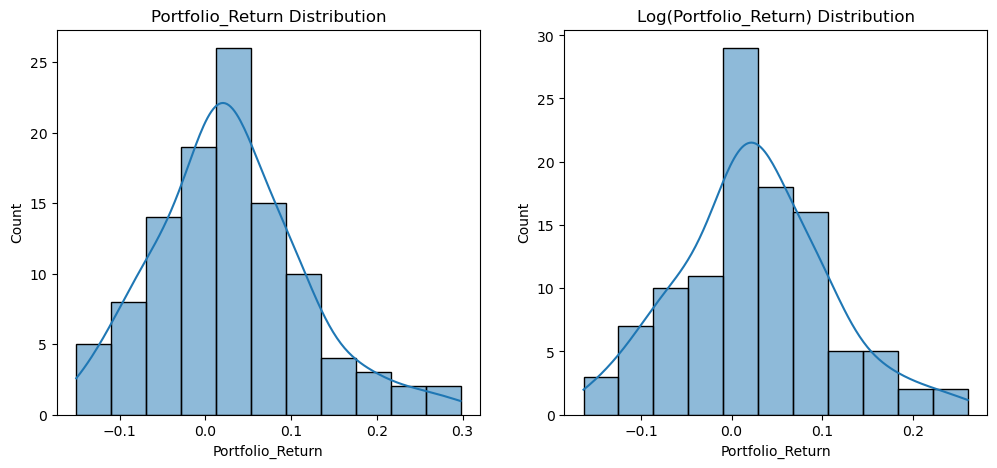

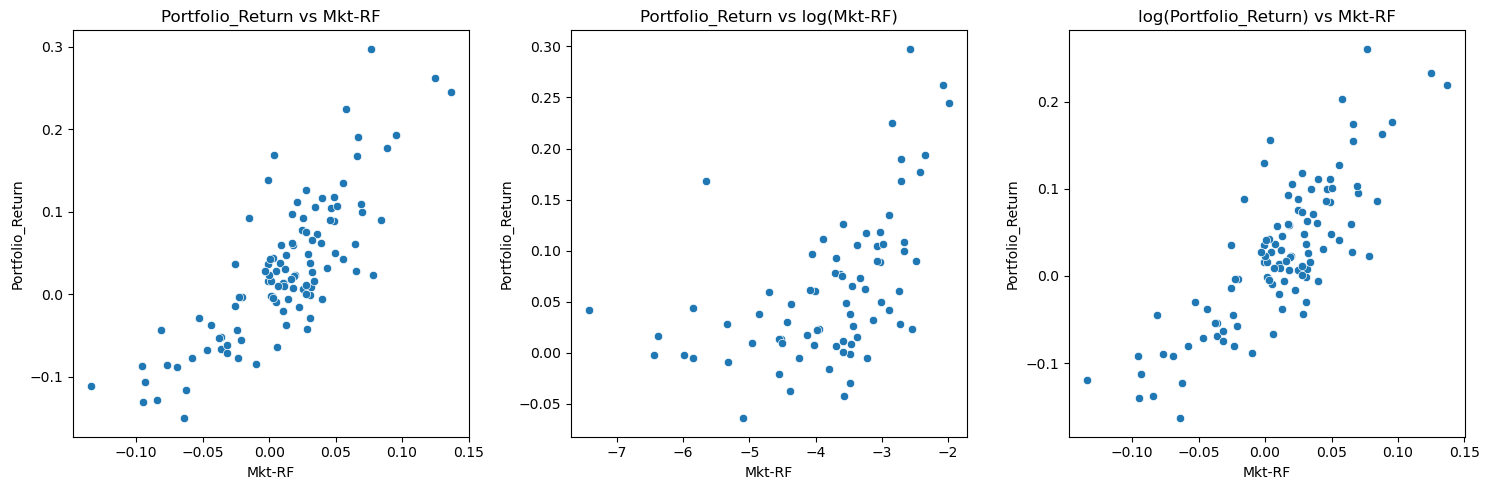

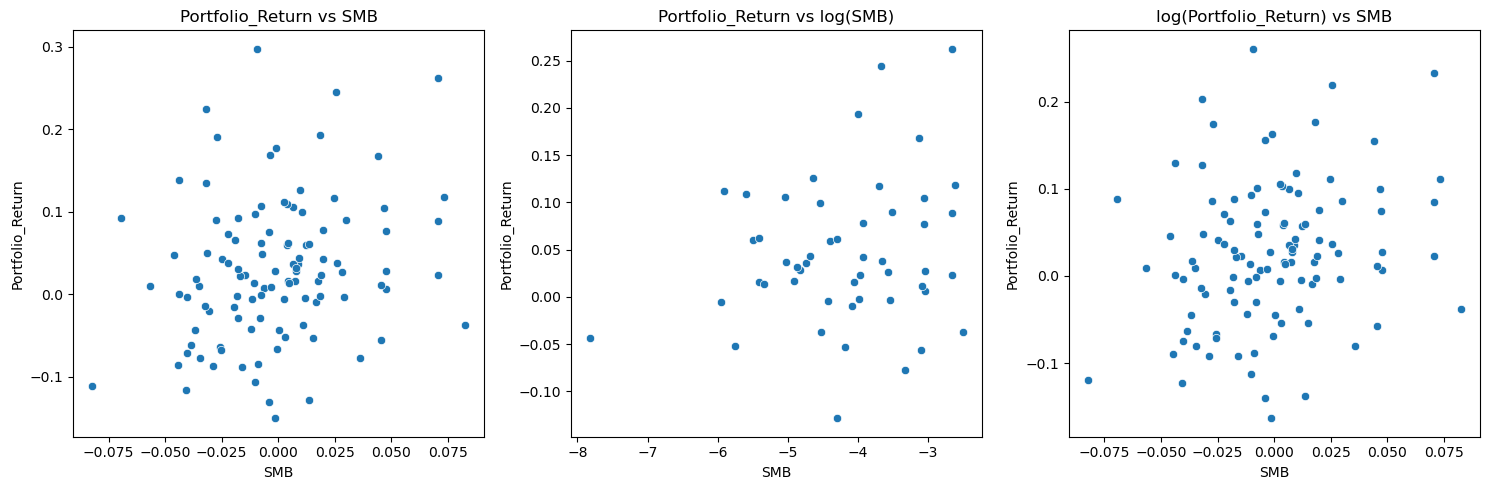

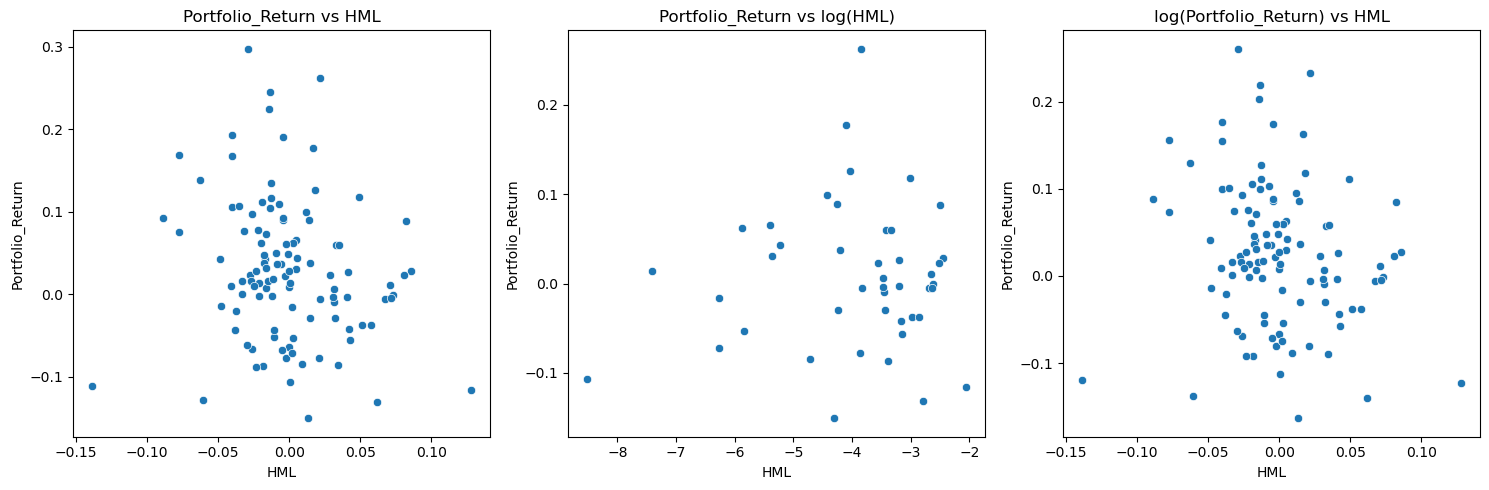

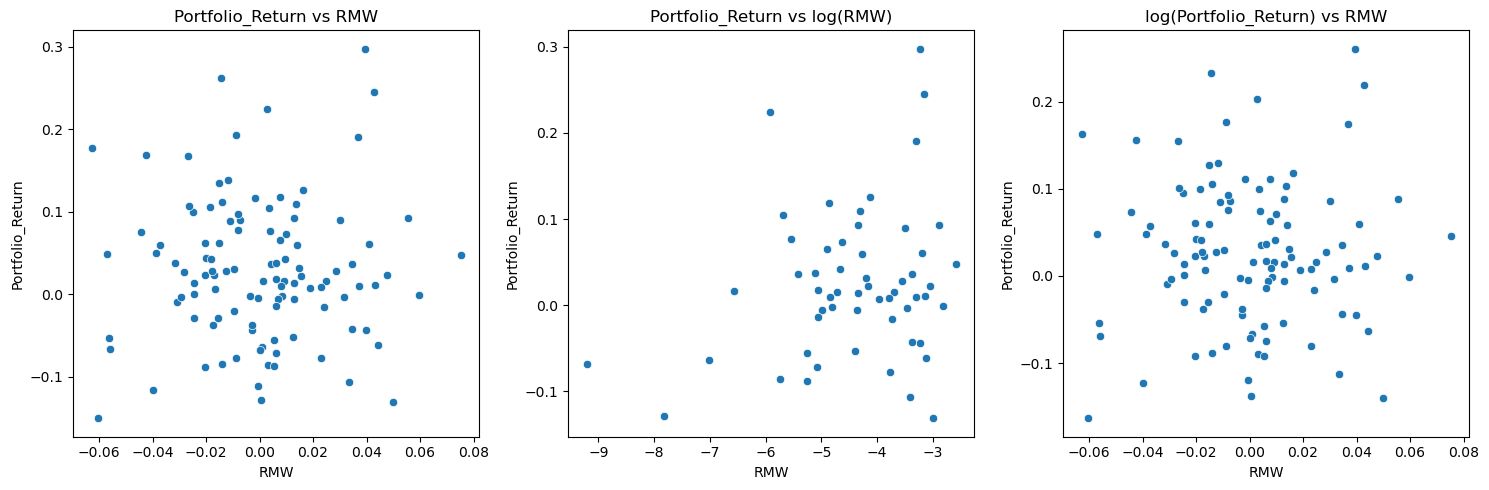

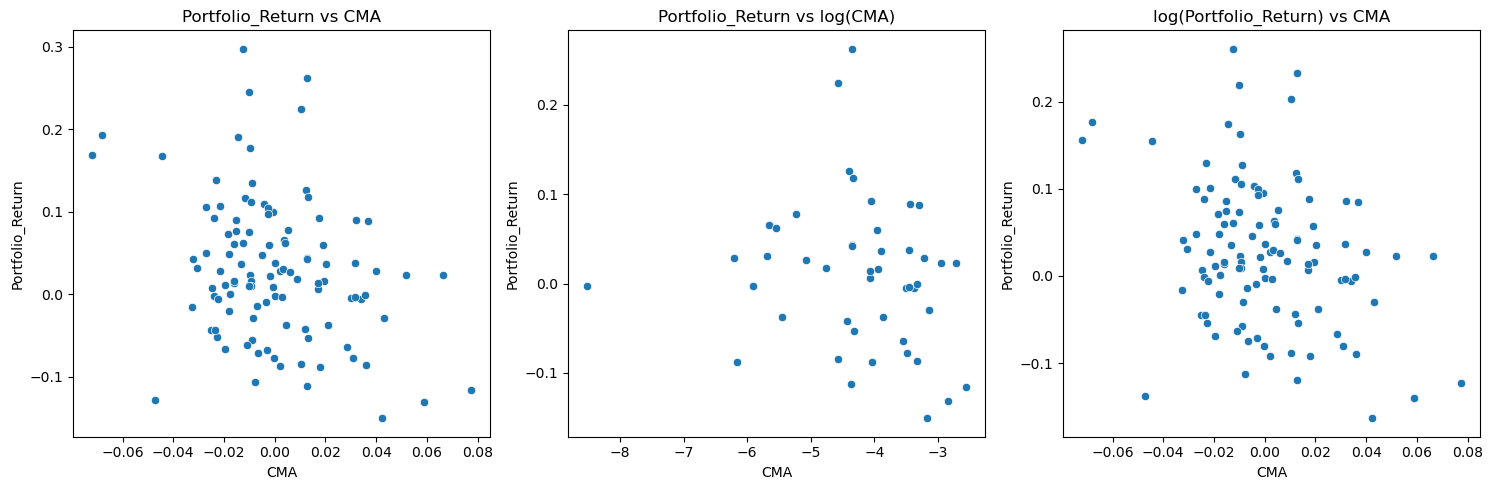

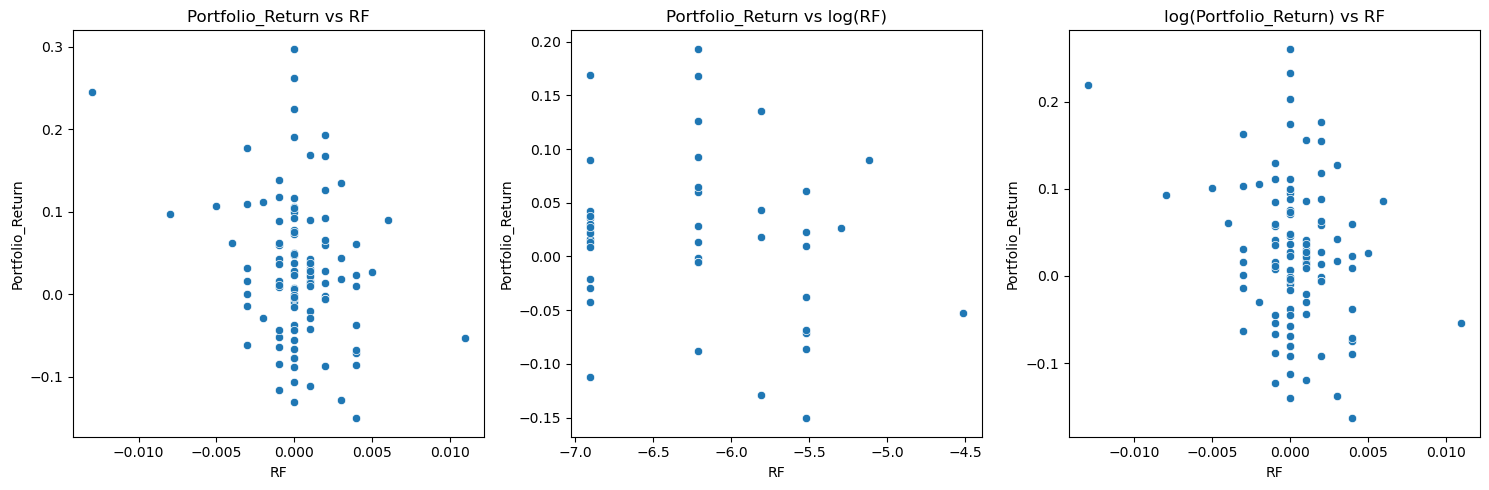

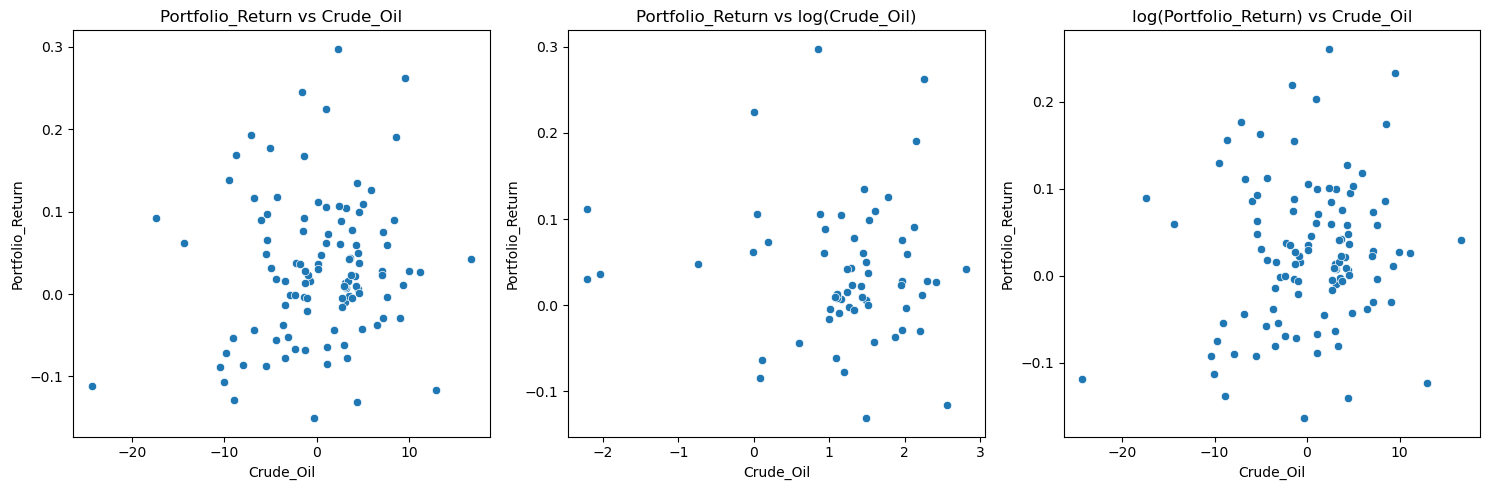

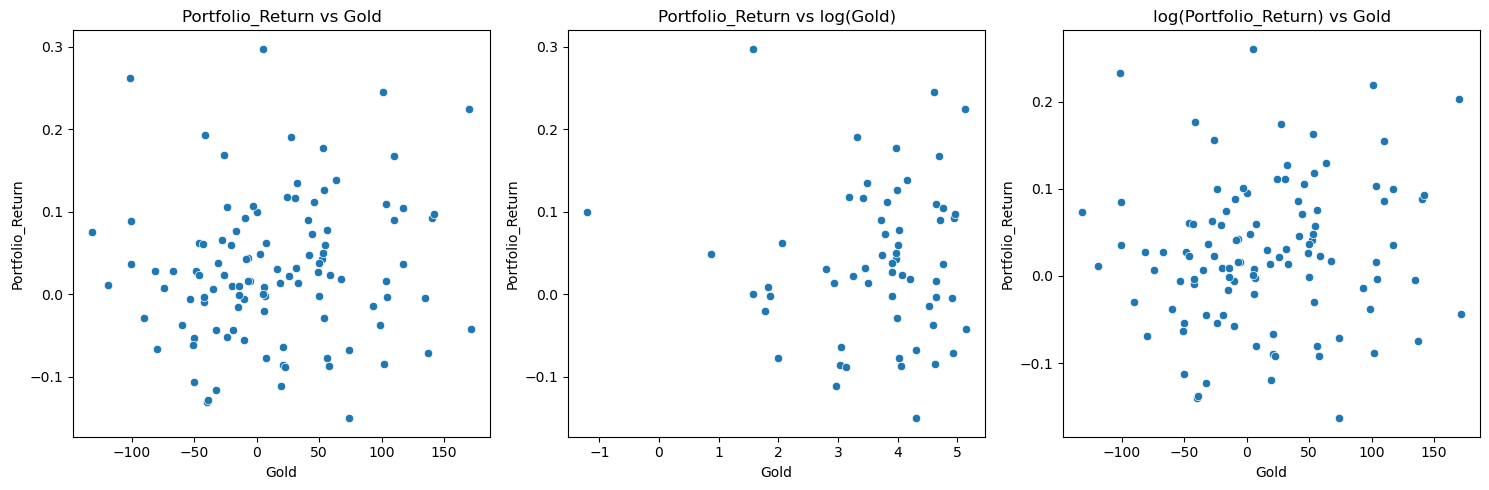

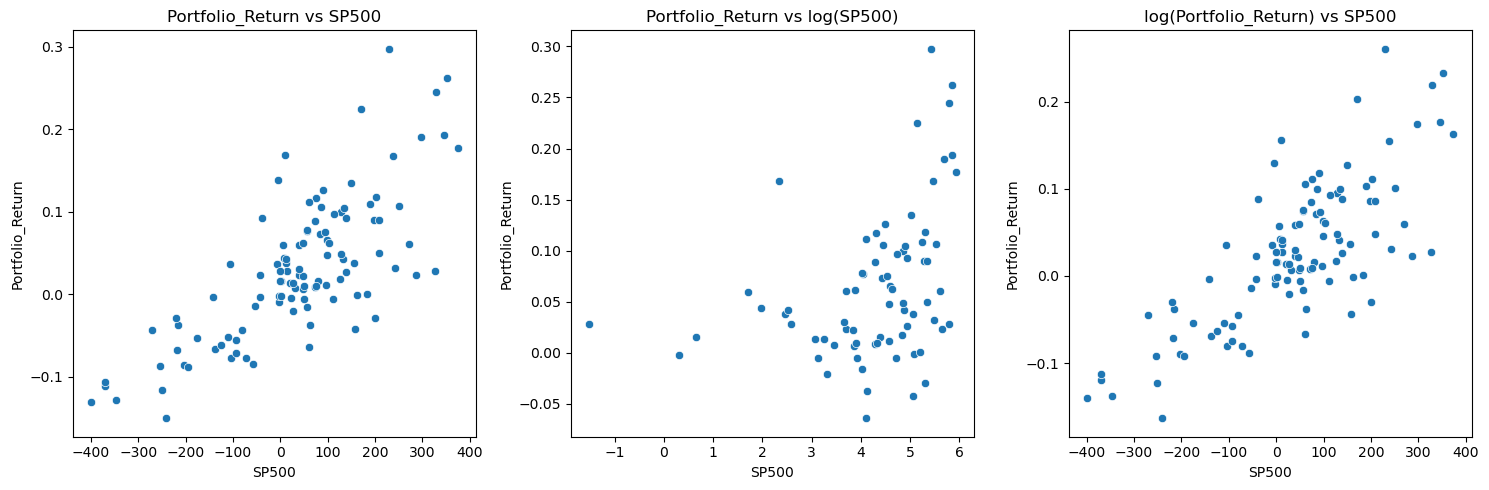

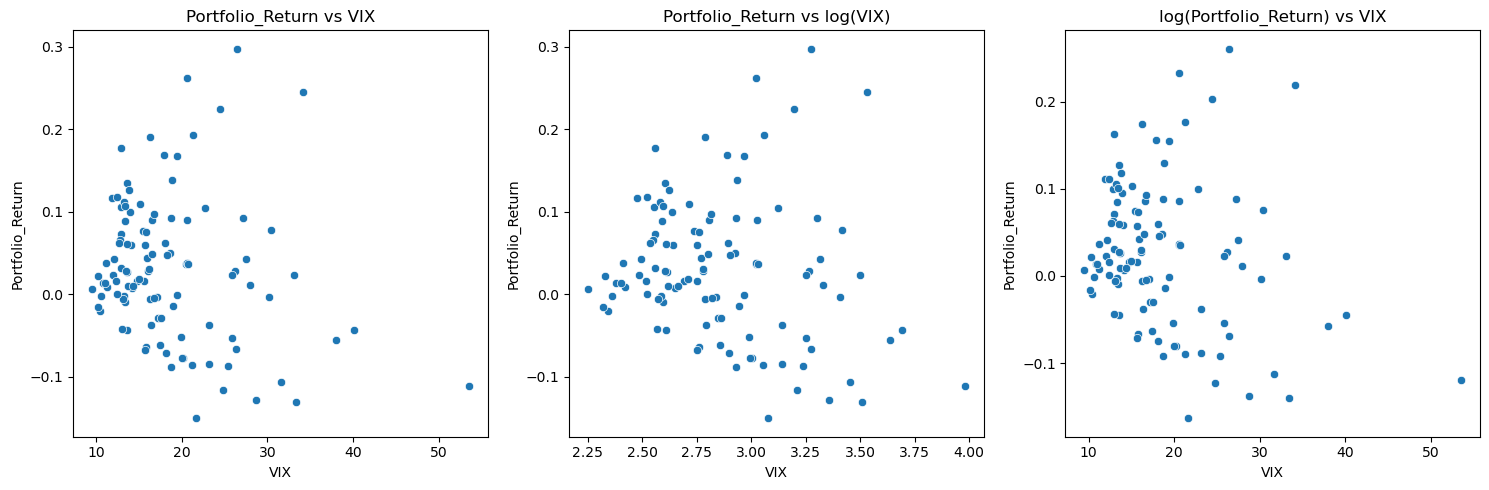

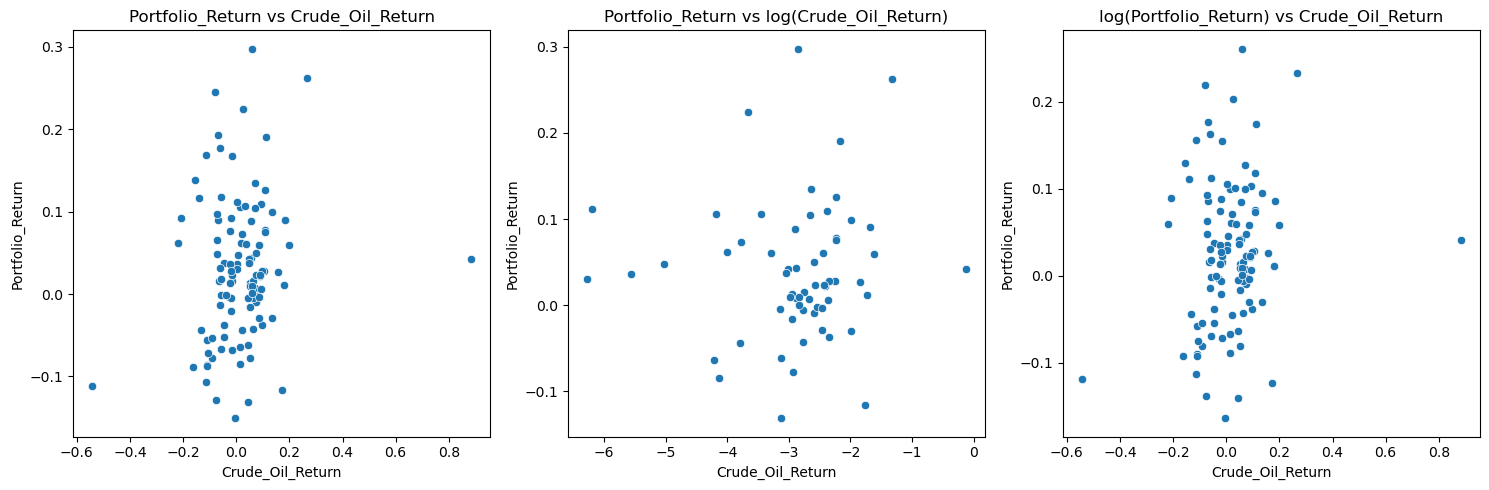

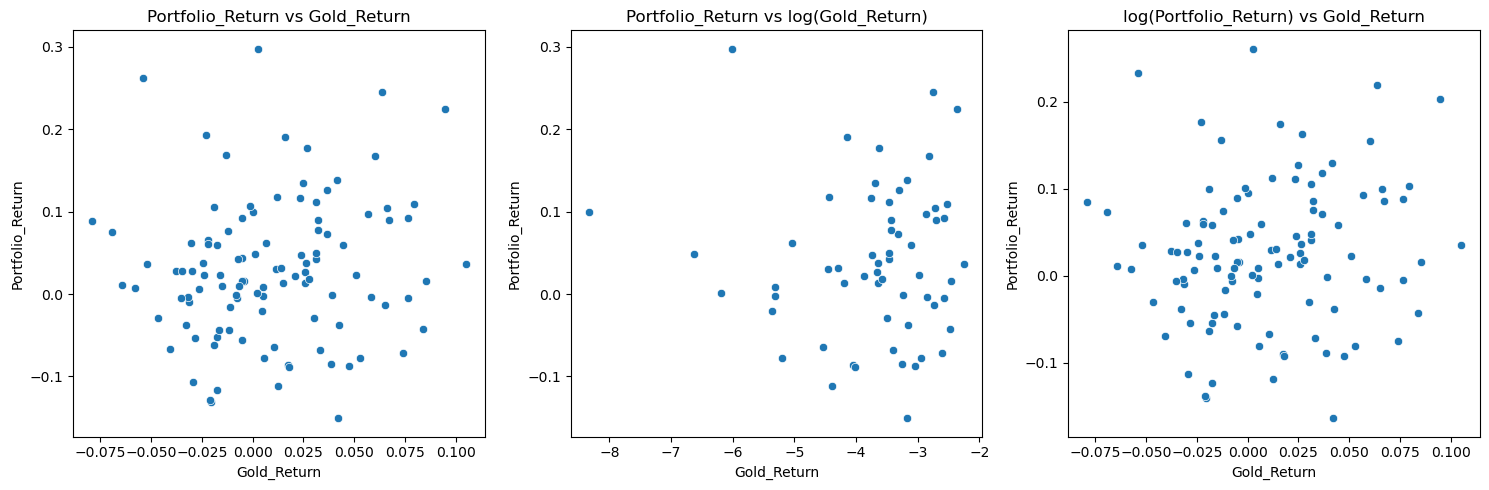

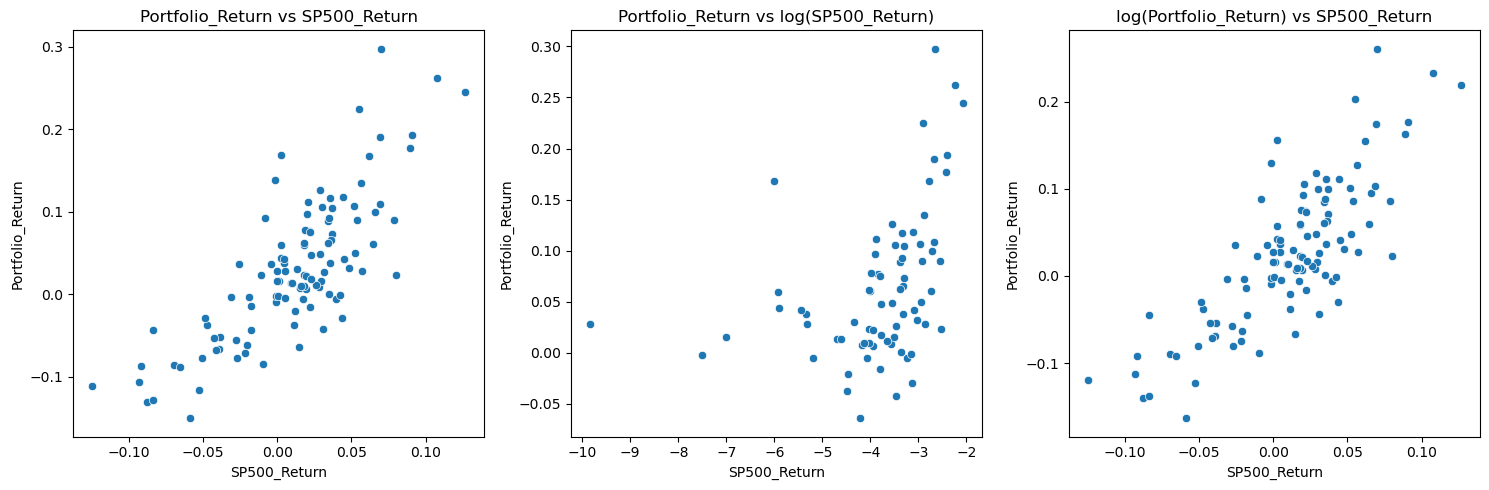

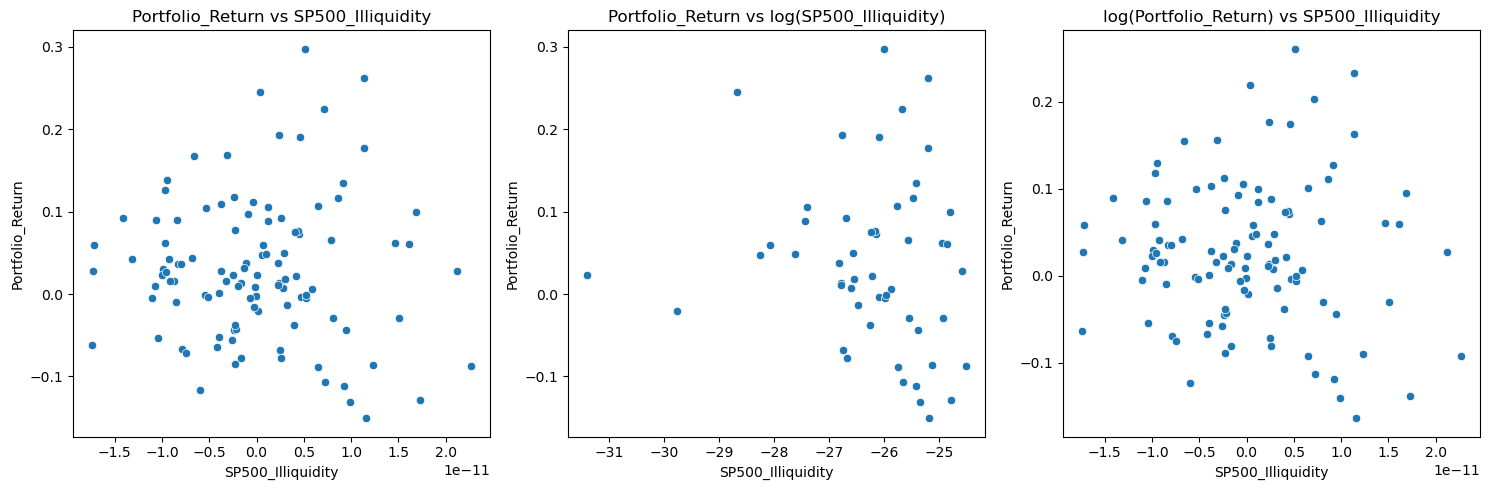

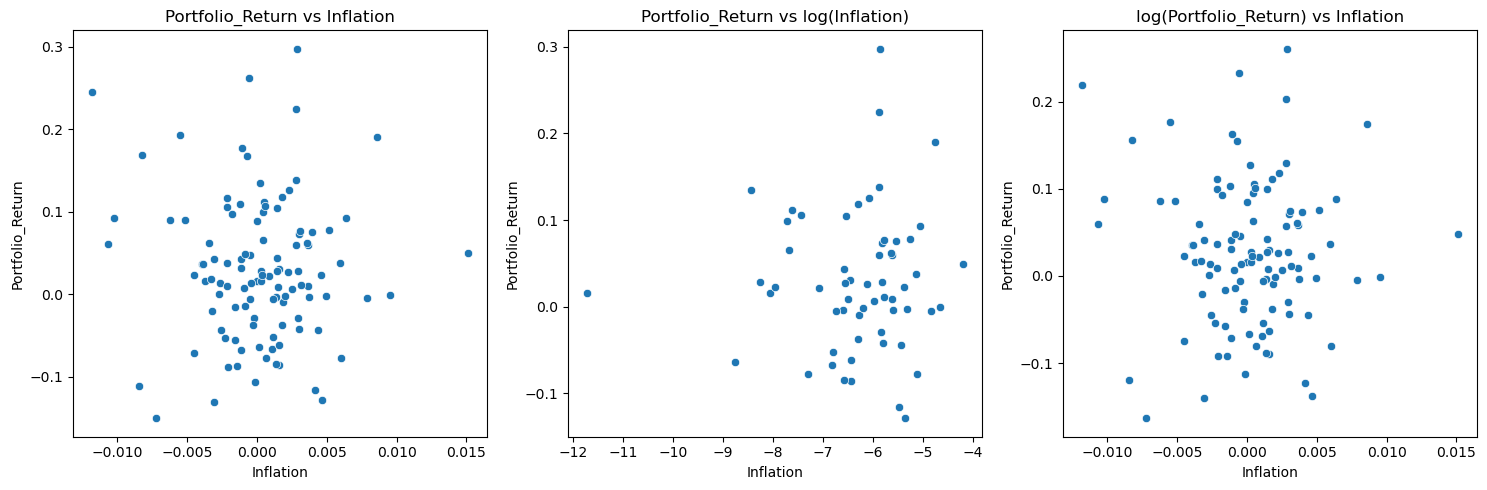

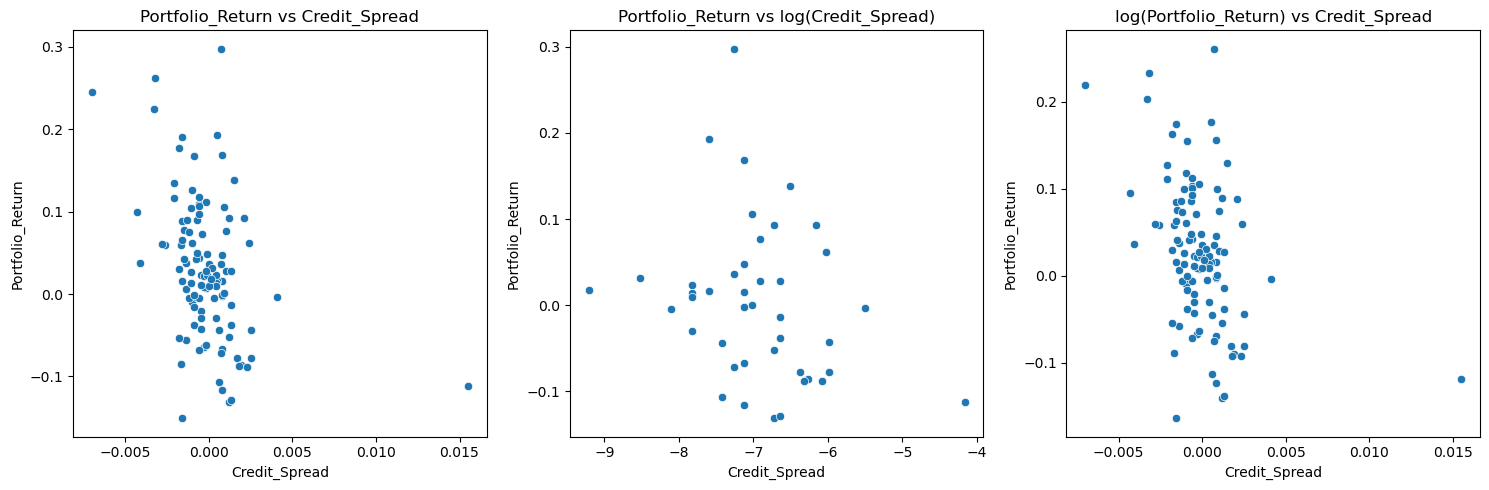

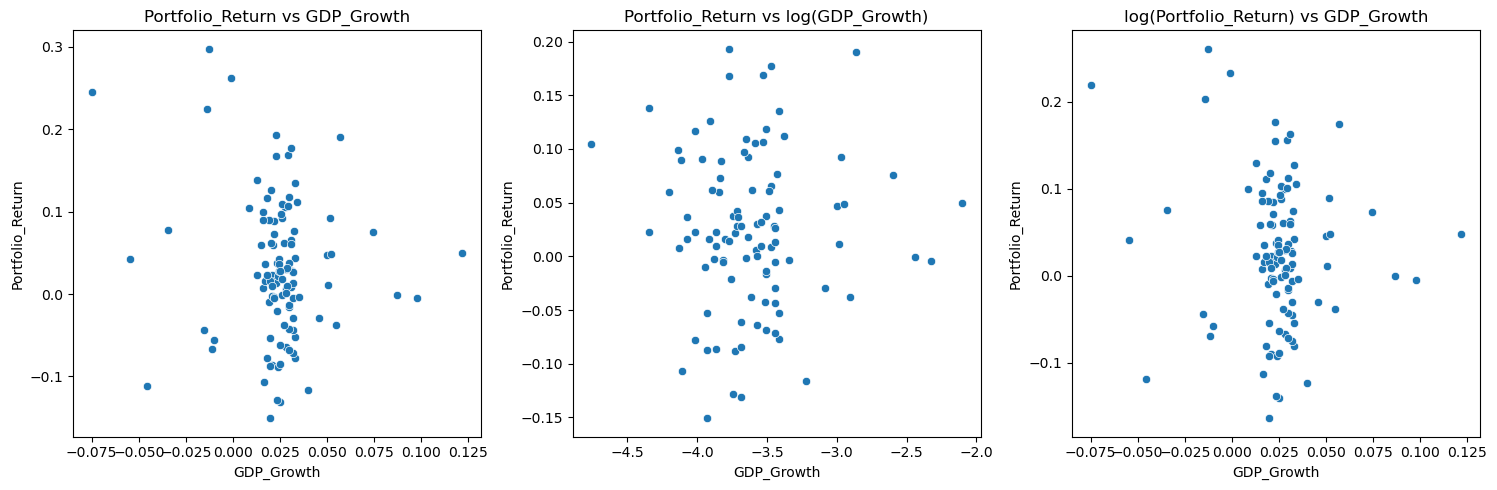

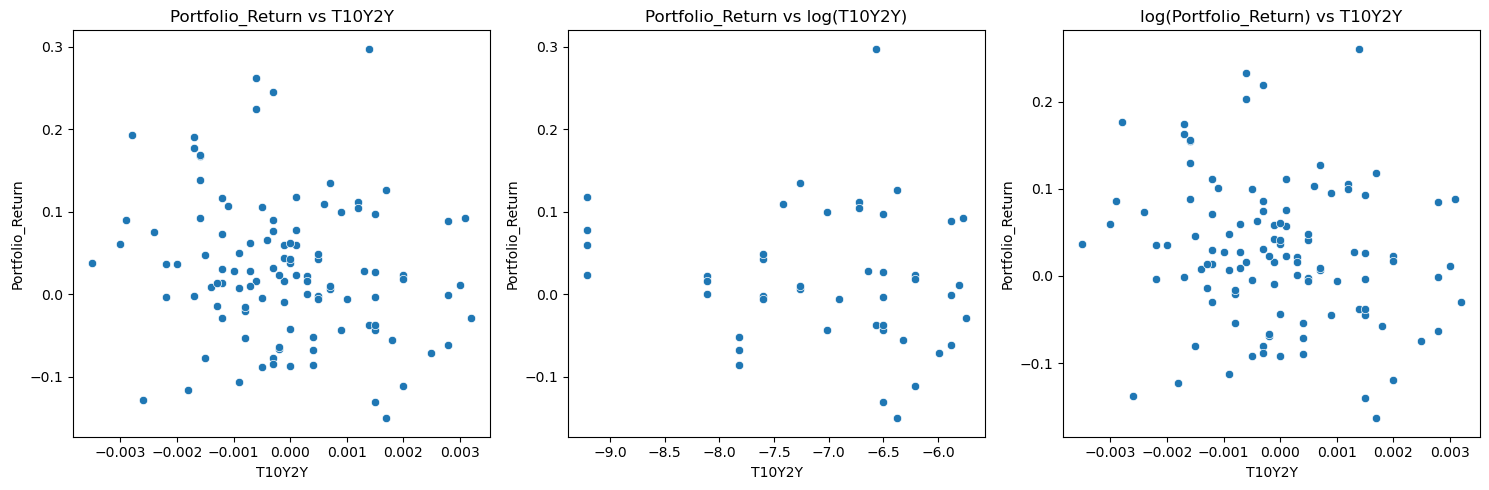

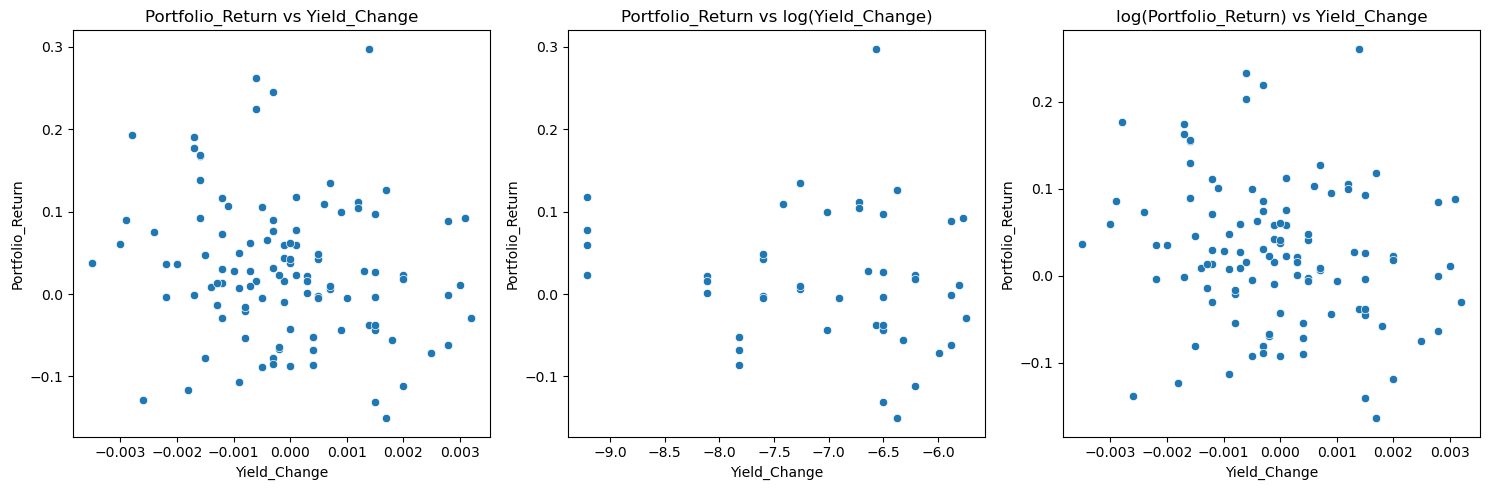

In [3]:
# Load and prepare data
df_portSummary = pd.read_csv('portfolio_summary.csv', parse_dates=['Date'], index_col='Date')
df_portDetail = pd.read_csv('portfolio_details.csv', parse_dates=['Date'], index_col='Date')
df_factor = pd.read_csv('factors.csv', parse_dates=['Date'], index_col='Date')
df = pd.merge(df_portSummary[['Portfolio_Return']], df_factor, 
              left_index=True, right_index=True, how='inner').sort_index()

stationary_df, diff_orders, dropped_cols = check_stationarity(df)
print(diff_orders)
plot_distributions(stationary_df)
    
# Prepare modeling data
data, scaler = prepare_model_data(stationary_df)

Note:

Portfolio Return Y Distribution: Exhibits right-skewness (positive skew), indicating non-normality.

Log-Transformed Log(Y): Improves normality, reduces skewness.

→ Use log transformation for modeling to better meet linear regression assumptions of normality.


##### Step 2: Modeling

In [4]:
# ===========================
# Model Evaluation
# ===========================
def evaluate_model(model, X, y, model_name="", plot_residuals=True, log=False):
    """Model evaluation with metrics and diagnostics."""
    y_pred = model.predict(X)
    if log==True:
        y_pred = np.expm1(y_pred)
    residuals = y - y_pred
    y_mean = np.mean(y)

    metrics = {
        "R²": r2_score(y, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y, y_pred)),
        "MAE": mean_absolute_error(y, y_pred),
        "Mean Residual": np.mean(residuals),
        "Residual Std": np.std(residuals)
    }
    
    print(f"\n{model_name.upper()} Evaluation")
    for name, value in metrics.items():
        print(f"{name:<25}: {value:.4f}{'%' if '%' in name else ''}")
    
    if plot_residuals:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        probplot(residuals, dist="norm", plot=axes[0])
        axes[0].set_title('Q-Q Plot of Residuals')
        sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
        axes[1].axhline(0, color='r', linestyle='--')
        axes[1].set_title('Residuals vs Predicted')
        plt.tight_layout()
        plt.show()
    
    return y_pred, metrics

# ===========================
# Model Implementations
# ===========================
def run_lasso(X_train, y_train, X_test, y_test, log=False):
    """Run Lasso regression with evaluation."""
    lasso = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5, random_state=42).fit(X_train, y_train)
    print(f"\nOptimal alpha: {lasso.alpha_:.4f}")
    
    y_pred, metrics = evaluate_model(lasso, X_test, y_test, model_name="Lasso Regression", log=False)
    
    # Feature analysis
    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': lasso.coef_,
        'Abs_Coefficient': np.abs(lasso.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop Features:")
    print(coef_df.head(10))
    
    return lasso, y_pred, metrics, coef_df

def run_gradient_boosting(X_train, y_train, X_test, y_test, n_estimators=200, max_depth=3, log=False):
    """Run Gradient Boosting with evaluation."""
    gbt = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                  learning_rate=0.1, random_state=42).fit(X_train, y_train)
    
    y_pred, metrics = evaluate_model(gbt, X_test, y_test, model_name="Gradient Boosting", plot_residuals=False, log=False)
    
    # Feature importance
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': gbt.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importances:")
    print(importance_df.head(10))
    
    # Partial dependence plots
    top_features = importance_df['Feature'].head(3).tolist()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, feature in enumerate(top_features):
        PartialDependenceDisplay.from_estimator(gbt, X_train, [feature], ax=axes[i])
    plt.tight_layout()
    plt.show()
    
    return gbt, y_pred, metrics

def run_pca_regression(X_train, y_train, X_test, y_test, variance_threshold=0.9, log=False):
    """Perform PCA regression."""
    pca = PCA().fit(X_train)
    n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= variance_threshold) + 1
    
    pca = PCA(n_components=n_components)
    X_train_pca = sm.add_constant(pca.fit_transform(X_train))
    X_test_pca = sm.add_constant(pca.transform(X_test))
    
    model = sm.OLS(y_train, X_train_pca).fit()
    y_pred, metrics = evaluate_model(model, X_test_pca, y_test, model_name="PCA Regression", log=False)
    
    return model, y_pred, metrics, pca, n_components

# ===========================
# Model Comparison
# ===========================

def compare_models(model_results):
    """Compare performance metrics across different models."""
    comparison_data = {}
    
    for model_name, result in model_results.items():
        if isinstance(result, tuple):
            # For models that return (model, y_pred, metrics)
            comparison_data[model_name] = result[2]
        elif isinstance(result, dict):
            # For models that return metrics directly
            comparison_data[model_name] = result
    
    comparison_df = pd.DataFrame(comparison_data).T
    
    # Visual comparison
    metrics_to_plot = ['R²', 'RMSE', 'MAE']
    comparison_df[metrics_to_plot].plot(kind='bar', subplots=True, 
                                     layout=(1,3), figsize=(15,5),
                                     legend=False)
    plt.suptitle('Model Performance Comparison')
    plt.tight_layout()
    plt.show()
    
    return comparison_df


Optimal alpha: 0.0075

LASSO REGRESSION Evaluation
R²                       : 0.7161
RMSE                     : 0.0551
MAE                      : 0.0463
Mean Residual            : -0.0032
Residual Std             : 0.0550


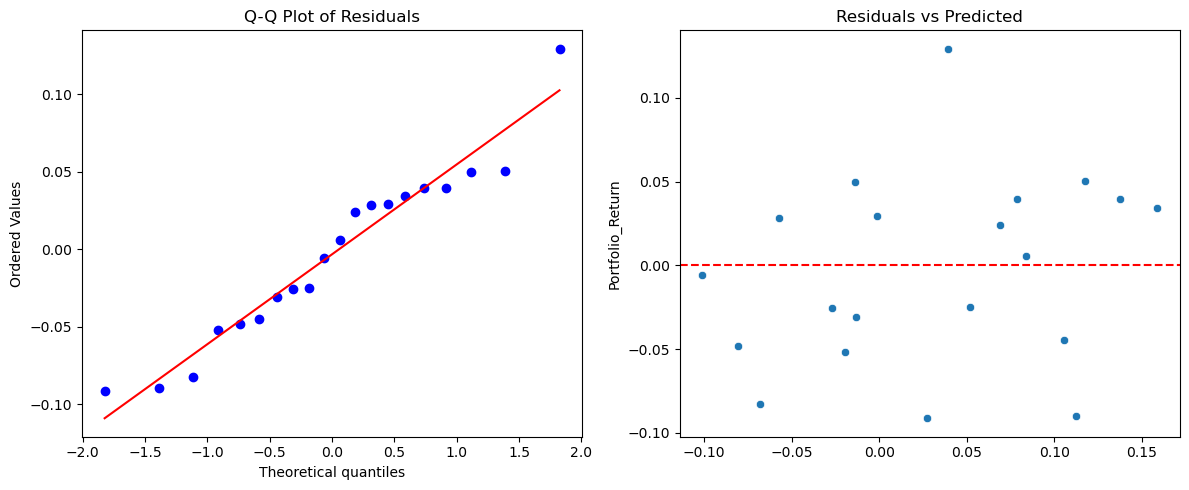


Top Features:
       Feature  Coefficient  Abs_Coefficient
0       Mkt-RF     0.061937         0.061937
2          HML    -0.006065         0.006065
6    Crude_Oil    -0.002410         0.002410
16  GDP_Growth    -0.001640         0.001640
9          VIX     0.001308         0.001308
7         Gold     0.000315         0.000315
5           RF    -0.000000         0.000000
4          CMA     0.000000         0.000000
8        SP500     0.000000         0.000000
1          SMB    -0.000000         0.000000

Optimal alpha: 0.0052

LASSO REGRESSION Evaluation
R²                       : 0.7270
RMSE                     : 0.0541
MAE                      : 0.0453
Mean Residual            : -0.0006
Residual Std             : 0.0541


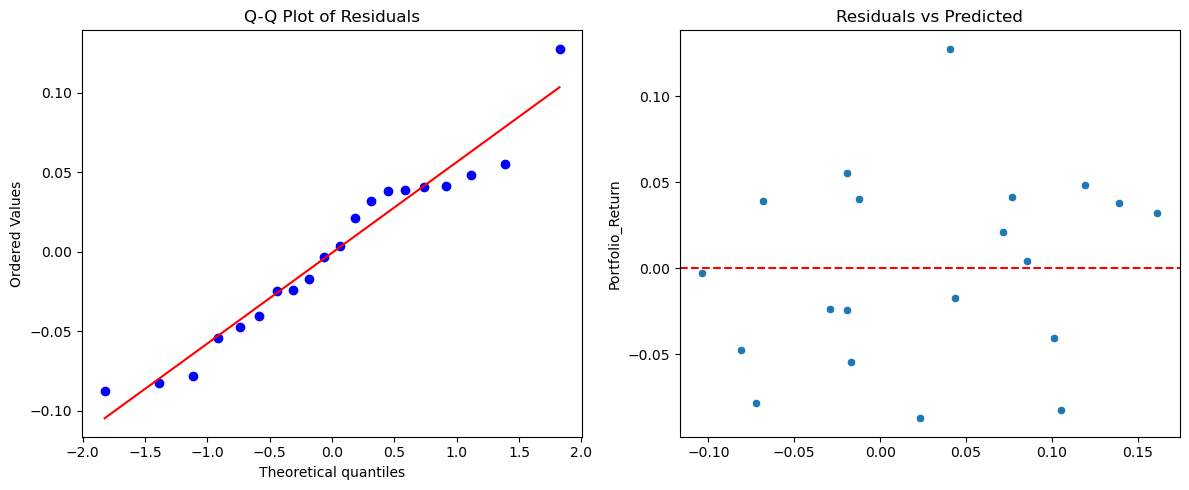


Top Features:
       Feature  Coefficient  Abs_Coefficient
0       Mkt-RF     0.063286         0.063286
2          HML    -0.007044         0.007044
6    Crude_Oil    -0.005185         0.005185
9          VIX     0.002110         0.002110
7         Gold     0.001551         0.001551
16  GDP_Growth    -0.000218         0.000218
4          CMA     0.000000         0.000000
5           RF    -0.000000         0.000000
3          RMW     0.000000         0.000000
8        SP500     0.000000         0.000000

GRADIENT BOOSTING Evaluation
R²                       : 0.3047
RMSE                     : 0.0863
MAE                      : 0.0721
Mean Residual            : -0.0195
Residual Std             : 0.0840

Feature Importances:
             Feature  Importance
12      SP500_Return    0.646024
8              SP500    0.122564
16        GDP_Growth    0.043330
9                VIX    0.040081
6          Crude_Oil    0.023337
1                SMB    0.019510
3                RMW    0.016965
10 

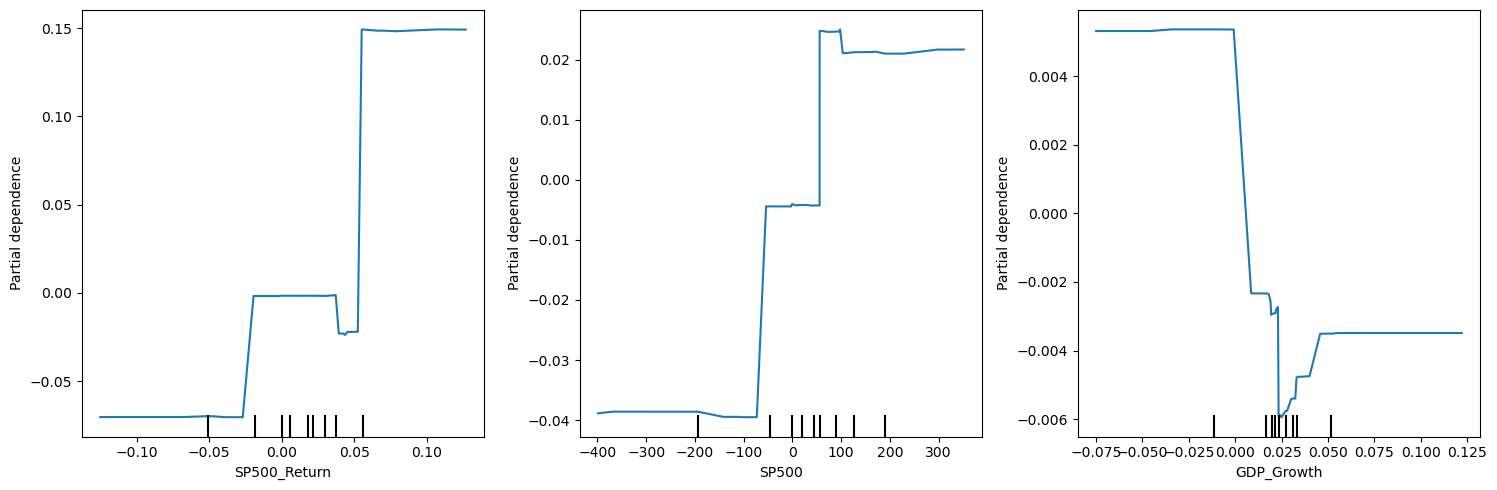


GRADIENT BOOSTING Evaluation
R²                       : 0.5859
RMSE                     : 0.0666
MAE                      : 0.0495
Mean Residual            : -0.0072
Residual Std             : 0.0662

Feature Importances:
             Feature  Importance
8              SP500    0.410266
12      SP500_Return    0.188972
0             Mkt-RF    0.183064
2                HML    0.036738
9                VIX    0.033010
16        GDP_Growth    0.027053
6          Crude_Oil    0.020351
4                CMA    0.020210
10  Crude_Oil_Return    0.013177
11       Gold_Return    0.013052


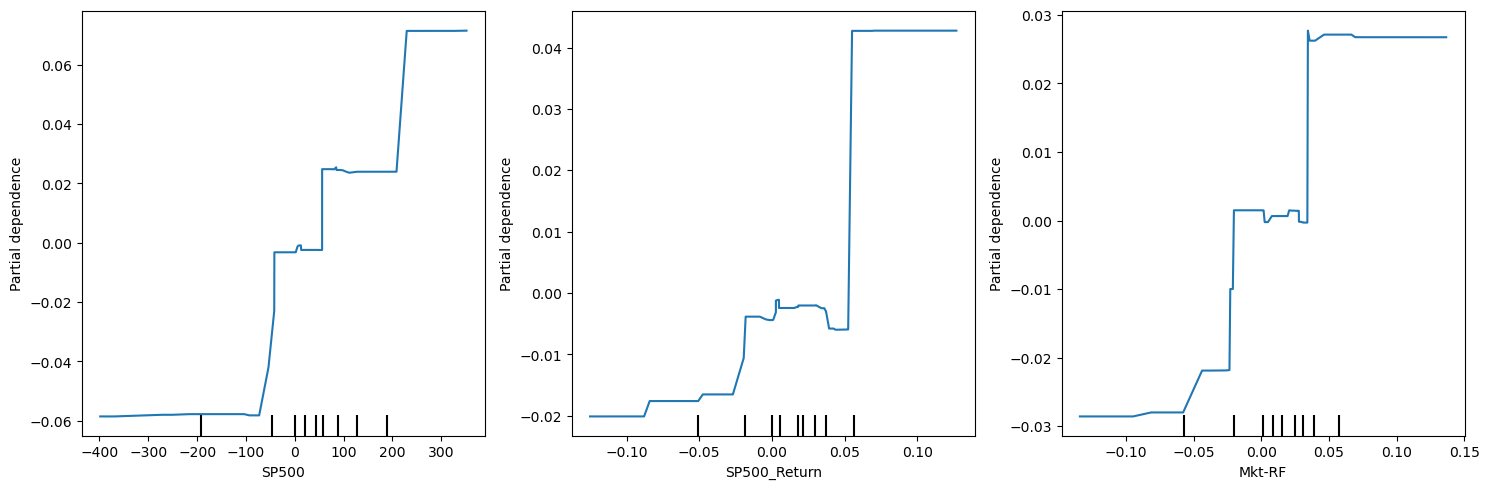


PCA REGRESSION Evaluation
R²                       : 0.6941
RMSE                     : 0.0572
MAE                      : 0.0462
Mean Residual            : 0.0076
Residual Std             : 0.0567


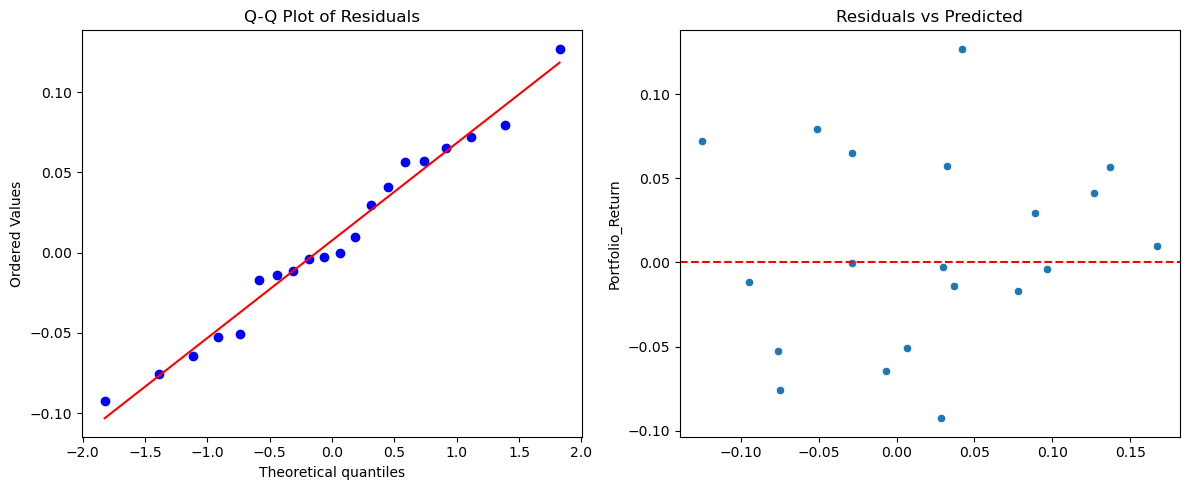


PCA REGRESSION Evaluation
R²                       : 0.7015
RMSE                     : 0.0565
MAE                      : 0.0458
Mean Residual            : 0.0093
Residual Std             : 0.0558


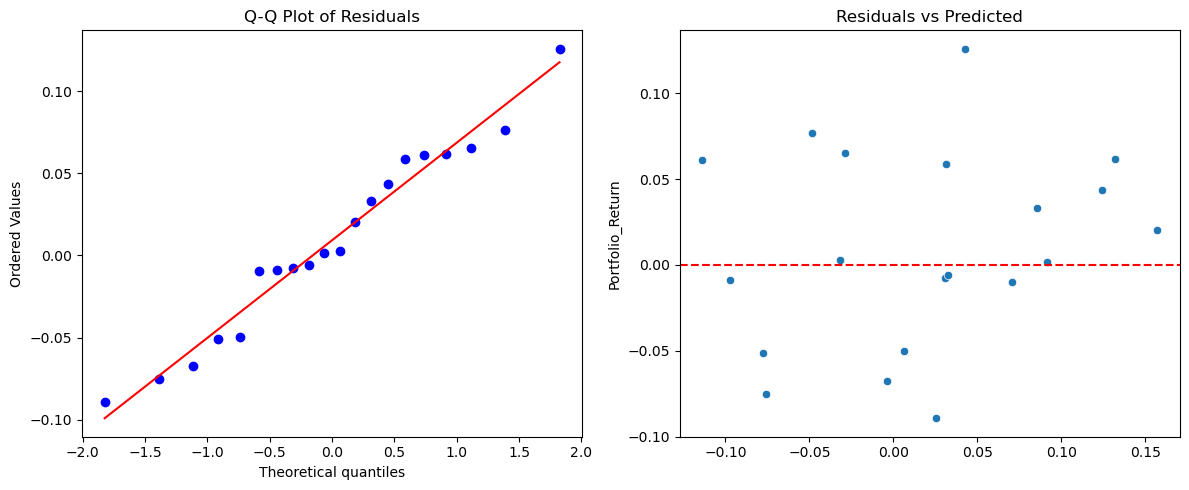

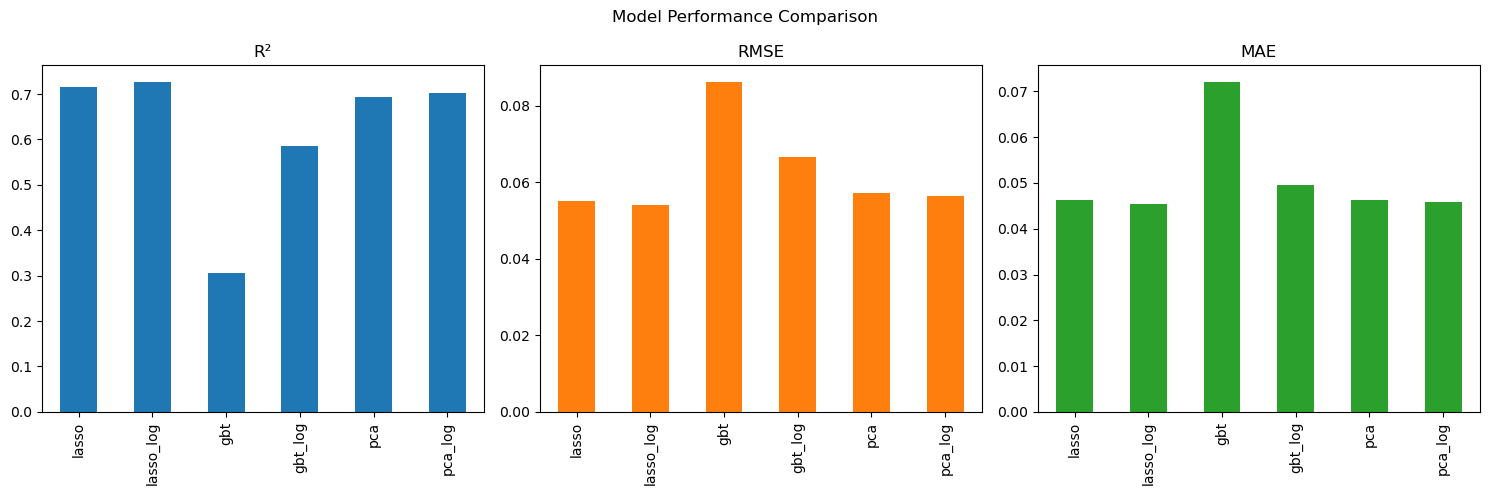


Model Performance Comparison:
                 R²      RMSE       MAE  Mean Residual
lasso      0.716125  0.055126  0.046266      -0.003190
lasso_log  0.726958  0.054064  0.045334      -0.000598
gbt        0.304722  0.086272  0.072108      -0.019469
gbt_log    0.585906  0.066580  0.049546      -0.007248
pca        0.694139  0.057221  0.046200       0.007586
pca_log    0.701527  0.056526  0.045765       0.009279


In [5]:
# ===========================
# Execution
# ===========================

# Model training and evaluation
model_results = {}
    
# Lasso models
lasso_model, lasso_y_pred, model_results['lasso'], lasso_coef_df  = run_lasso(data['X_train_scaled'], data['y_train'], 
                            data['X_test_scaled'], data['y_test'])
lassoLog_model, lassoLog_y_pred, model_results['lasso_log'], lassoLog_coef_df = run_lasso(data['X_train_scaled'], data['y_train_log'], 
                                data['X_test_scaled'], data['y_test'], log=True)
    
# Gradient Boosting models
gbt_model, gbt_y_pred, model_results['gbt'] = run_gradient_boosting(data['X_train'], data['y_train'], 
                                        data['X_test'], data['y_test'], max_depth=50)
gbtLog_model, gbtLog_y_pred, model_results['gbt_log'] = run_gradient_boosting(data['X_train'], data['y_train_log'], 
                                        data['X_test'], data['y_test'], log=True)
    
# PCA models
pca_model, pca_y_pred, model_results['pca'], pca, pca_n_componentsg = run_pca_regression(data['X_train_scaled'], data['y_train'], 
                                        data['X_test_scaled'], data['y_test'])
pcaLog_model, pcaLog_y_pred, model_results['pca_log'], pcaLog, pcaLog_n_components = run_pca_regression(data['X_train_scaled'], data['y_train_log'], 
                                            data['X_test_scaled'], data['y_test'], log=True)
    
# Model comparison
comparison_df = compare_models(model_results)
print("\nModel Performance Comparison:")
print(comparison_df[['R²', 'RMSE', 'MAE', 'Mean Residual']])

Note:
1. Best Model Selection
+ Lasso with log(y): Best model, with highest R², lowest RMSE/MAE, relatively small bias, indicating the best predictive accuracy.
+ PCA with log(y): Provides useful insights but may not ideal for prediction, since Mean Residual is relatively high.

2. Impact of Log Transformation
+ Universal improvement: All models (Lasso, GBT, PCA) perform better with log(y).
+ Most impactful for GBT: R² jumps from 0.30 → 0.59, resolving severe underfitting.

3. Systematic Bias
+ Lasso, GBT Models tend to overpredict (Mean Residual < 0).
+ PCA models tend to underpredict (Mean Residual > 0).
Underprediction is preferable in return forecasting, as overprediction can lead to excessive risk-taking.

4. Residual Analysis
+ QQ-Plot: Most residuals in the middle range follow the 45-degree line, suggesting an approximately normal distribution. However, heavy tails indicate the model does not fully capture extreme values, leading to occasional large errors.
+ Residuals vs. Predicted Plot: No clear pattern, meaning heteroscedasticity is not a major issue. However, wide residual spread suggests possible non-linearity or missing risk factors in the model.

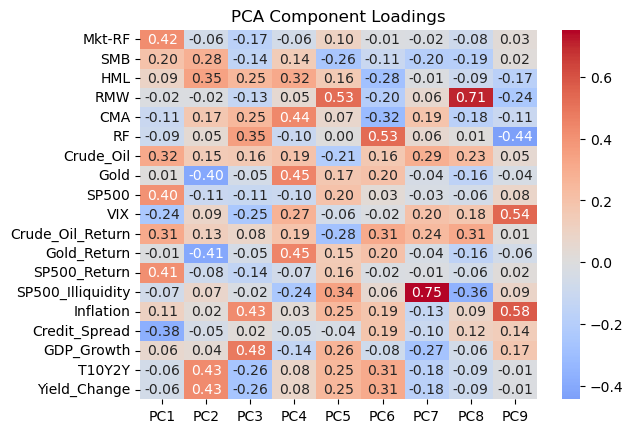

In [6]:
# PCA Loadings analysis
loadings = pd.DataFrame(pcaLog.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pcaLog_n_components)],
                        index=data['X_train_scaled'].columns)
plt.plot(figsize=(10,8))    
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title('PCA Component Loadings')
plt.show()

Interpretation of PCA Components:
- PC1: Equity market movement
- PC2: Yield-gold dynamic - negative
- PC3: Economic growth expectations
- PC4: Defensive investing
- PC5: Quality-Profitability
- PC6: Risk-free rate 
- PC7: Liquidity risk
- PC8: Alternative Profitability
- PC9: Inflation Sensitivity

##### Step 3: Portfolio Risk Decomposition

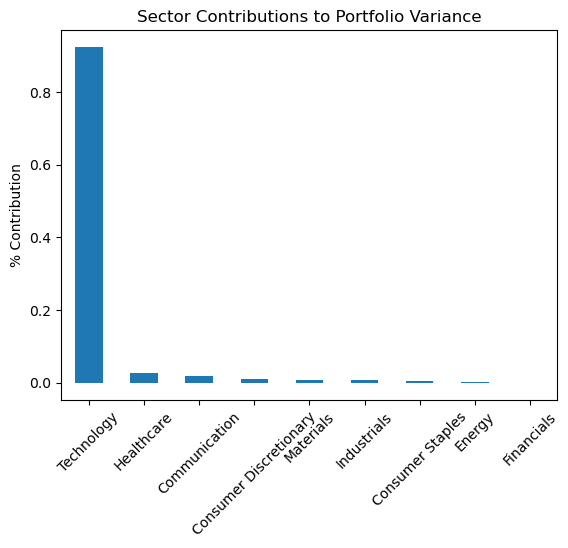

Technology                0.924055
Healthcare                0.027558
Communication             0.018484
Consumer Discretionary    0.009477
Materials                 0.008559
Industrials               0.007403
Consumer Staples          0.004189
Energy                    0.000927
Financials               -0.000651
dtype: float64


In [7]:
# ===========================
# Risk by Sectors
# ===========================

# Calculate sector return
sector_weight_cols = [col for col in df_portSummary.columns if col.startswith('Sector_')]
sector_names = [col.replace('Sector_', '') for col in sector_weight_cols]

for sector in sector_names:
    # Sector value = Portfolio value * Sector weight
    df_portSummary[f'{sector}_Value'] = df_portSummary['Portfolio_Value'] * df_portSummary[f'Sector_{sector}']
    # Sector return = Percentage change in sector value
    df_portSummary[f'{sector}_Return'] = df_portSummary[f'{sector}_Value'].pct_change()
df_portSummary.dropna(inplace=True)
df_portSummary.rename(columns={
    f'Sector_{sector}': f'{sector}_Wgt' 
    for sector in sector_names
}, inplace=True)

# Ensure consistent sector order
sector_names_sorted = sorted(sector_names)
return_cols = [f'{sector}_Return' for sector in sector_names_sorted]
weight_cols = [f'{sector}_Wgt' for sector in sector_names_sorted]

backtest_portSummary = df_portSummary['2024-01-01':]
sector_returns = backtest_portSummary[return_cols]
sector_weights = backtest_portSummary[weight_cols].mean().to_numpy() # Sector weights

# Sector covariance matrix 
sector_cov_matrix = sector_returns.cov()
# Portfolio variance from sectors
sector_portfolio_variance = sector_weights.T @ sector_cov_matrix @ sector_weights
annualized_variance = sector_portfolio_variance * 12

# Sector contributions
sector_marginal_contributions = sector_weights * (sector_cov_matrix @ sector_weights)
sector_contributions = sector_marginal_contributions / sector_portfolio_variance
sector_contributions.index = [s.replace('_Return', '') for s in sector_contributions.index]
sector_contributions = sector_contributions.sort_values(ascending=False)

# Visualize decomposition
sector_contributions.plot(
    kind='bar', title='Sector Contributions to Portfolio Variance'
)
plt.ylabel('% Contribution')
plt.xticks(rotation=45)
plt.show()
print(sector_contributions)

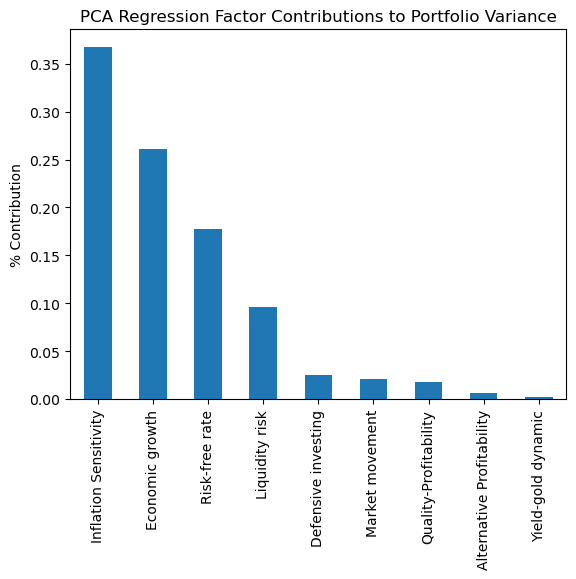

Inflation Sensitivity        0.367533
Economic growth              0.261340
Risk-free rate               0.177505
Liquidity risk               0.096001
Defensive investing          0.024851
Market movement              0.021195
Quality-Profitability        0.017616
Alternative Profitability    0.005875
Yield-gold dynamic           0.002116
dtype: float64


In [8]:
# ===========================
# Risk by Model Factors - PCA Regression
# ===========================
# Transform data
X_backtest = stationary_df['2023-12-31':].drop(columns=['Portfolio_Return'])
y_backtest = stationary_df['2023-12-31':]['Portfolio_Return']
X_backtest_scaled = scaler.transform(X_backtest)
y_backtest_log = np.log1p(y_backtest)
# PCA returns
pcaLog_backtest_returns = pcaLog.transform(X_backtest_scaled)
# Fit OLS model
X_backtest_pca = sm.add_constant(pcaLog_backtest_returns)
pcaLog_backtest_model = sm.OLS(y_backtest_log, X_backtest_pca).fit()
# PCA Betas
pcaLog_betas = pcaLog_backtest_model.params[1:] 

# Variance of each PC
pcaLog_variances = np.var(pcaLog_backtest_returns, axis=0)
# Systematic variance from PCA factors
systematic_variance = sum(pcaLog_betas**2 * pcaLog_variances)
# Total variance
residual_variance = np.var(pcaLog_backtest_model.resid)
total_variance = systematic_variance + residual_variance

# Factor contributions
pcaLog_marginal_contributions = pcaLog_betas**2 * pcaLog_variances
pcaLog_factor_risk_contributions = pcaLog_marginal_contributions / total_variance
pca_index_mapping = {
    'x1': 'Market movement',
    'x2': 'Yield-gold dynamic',
    'x3': 'Economic growth',
    'x4': 'Defensive investing',
    'x5': 'Quality-Profitability',
    'x6': 'Risk-free rate',
    'x7': 'Liquidity risk',
    'x8': 'Alternative Profitability',
    'x9': 'Inflation Sensitivity'
}
pcaLog_factor_risk_contributions.index = pcaLog_factor_risk_contributions.index.map(pca_index_mapping)
pcaLog_factor_risk_contributions = pcaLog_factor_risk_contributions.sort_values(ascending=False)

# Visualize decomposition
pcaLog_factor_risk_contributions.plot(
    kind='bar', title='PCA Regression Factor Contributions to Portfolio Variance'
)
plt.ylabel('% Contribution')
plt.xticks()
plt.show()
print(pcaLog_factor_risk_contributions)

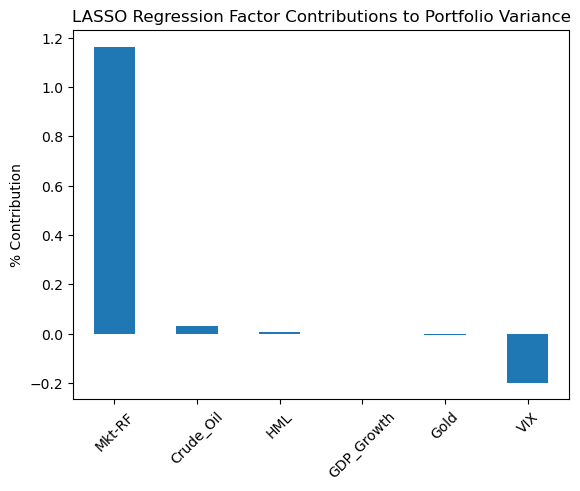

Mkt-RF        1.163833
Crude_Oil     0.031463
HML           0.007729
GDP_Growth    0.000001
Gold         -0.004357
VIX          -0.198669
dtype: float64


In [9]:
# ===========================
# Risk by Model Factors - LASSO Regression
# ===========================
# Calculate factor return
lassoLog_factors = lassoLog_coef_df[lassoLog_coef_df['Coefficient'] != 0]['Feature'].tolist()
lassoLog_factor_data = data['backtest'][lassoLog_factors]
transform_factors = ['Crude_Oil','Gold']
lassoLog_factor_transformed = pd.merge(lassoLog_factor_data[transform_factors], df_factor[transform_factors], 
              left_index=True, right_index=True, how='inner', suffixes=('_Diff', '_Original')).sort_index()
for factor in transform_factors:
    lassoLog_factor_transformed[f'{factor}'] = lassoLog_factor_transformed[f'{factor}_Diff'] / lassoLog_factor_transformed[f'{factor}_Original'].shift(1)

lassoLog_factor_return = pd.merge(lassoLog_factor_data.drop(columns=transform_factors, errors='ignore'),
                                  lassoLog_factor_transformed[transform_factors],
                                  left_index=True, right_index=True, how='inner').sort_index()

for col in lassoLog_factors:
    new_name = f"{col}_Return"
    if lassoLog_factor_return[col].abs().max() > 1:
        lassoLog_factor_return[new_name] = lassoLog_factor_return[col].pct_change()
    else:
        lassoLog_factor_return[new_name] = lassoLog_factor_return[col]
    
    lassoLog_factor_return.drop(columns=[col], inplace=True)
lassoLog_factor_return.dropna(inplace=True)

# Factor beta
lassoLog_betas = lassoLog_coef_df.set_index('Feature').loc[lassoLog_factors]['Coefficient'].values
# Factor covariance matrix
lassoLog_factor_cov_matrix = lassoLog_factor_return.cov()
# Portfolio variance from factors
lassoLog_portfolio_variance = lassoLog_betas.T @ lassoLog_factor_cov_matrix @ lassoLog_betas

# Factor contributions
lassoLog_marginal_contributions = lassoLog_betas * (lassoLog_factor_cov_matrix @ lassoLog_betas)
LassoLog_factor_risk_contributions = lassoLog_marginal_contributions / lassoLog_portfolio_variance
LassoLog_factor_risk_contributions.index = [s.replace('_Return', '') for s in LassoLog_factor_risk_contributions.index]
LassoLog_factor_risk_contributions = LassoLog_factor_risk_contributions.sort_values(ascending=False)

# Visualize decomposition
LassoLog_factor_risk_contributions.plot(
    kind='bar', title='LASSO Regression Factor Contributions to Portfolio Variance'
)
plt.ylabel('% Contribution')
plt.xticks(rotation=45)
plt.show()
print(LassoLog_factor_risk_contributions)

##### Step 4: Backtest VaR & ES

In [10]:
y_training = stationary_df[:'2024-01-01']['Portfolio_Return']
y_backtest = data['backtest']['Portfolio_Return']
X_backtest = data['backtest'].drop(columns=['Portfolio_Return'])
X_backtest_scaled = scaler.transform(X_backtest)

# ===========================
# ARIMA + GARCH VaR 
# ===========================
# 1. Fit ARIMA to returns
arima = ARIMA(y_training, order=(1, 0, 1))  
arima_result = arima.fit()
residuals = arima_result.resid  # Residuals for GARCH

# 2. Fit GARCH to ARIMA residuals
garch = arch_model(residuals, vol='GARCH', p=1, q=1, dist='t')
garch_result = garch.fit(update_freq=5, disp='off')

# 3. Forecast VaR (ARIMA+GARCH)
forecasts = []
test_window = y_backtest.copy()

# Walk-forward VaR forecasting
for i in range(len(test_window)):
    if i > 0:
        arima_result = arima_result.append([test_window.iloc[i-1]])
    # Forecast mean (ARIMA)
    mean_forecast = arima_result.forecast(steps=1).iloc[0]
    
    # Forecast volatility (GARCH)
    vol_forecast = garch_result.forecast(horizon=1, reindex=False).variance.iloc[0,0]**0.5
    
    # Calculate 95% VaR 
    nu = garch_result.params['nu']  # Degrees of freedom for t-dist
    var = mean_forecast + vol_forecast * -t.ppf(0.95, df=nu)
    forecasts.append(var)

garch_pred_var = pd.Series(forecasts, index=y_backtest.index)

# 4. Backtest VaR
garch_var_violations = (y_backtest < garch_pred_var).sum()
# Unconditional Coverage Test
garch_uc_pvalue = binom_test(garch_var_violations, n=len(y_backtest), p=0.05)


# ===========================
# Historical VaR 
# ===========================
# 1. Historical VaR Calculation
def historical_var(returns, window=12, alpha=0.05):
    """Rolling window Historical VaR"""
    return returns.rolling(window).quantile(alpha)

train_var = historical_var(y_training)

# 2. Backtesting
hist_pred_var = historical_var(pd.concat([y_training, y_backtest]), window=12)[len(y_training):]

# 3. Backtest Results
hist_var_violations = (y_backtest < hist_pred_var).sum()
hist_uc_pvalue = binom_test(hist_var_violations, n=len(y_backtest), p=0.05)

# ===========================
# LASSO Regresion VaR 
# ===========================
# Calculate 5th percentile of model residuals
lassoLog_y_pred_unlog =  np.expm1(lassoLog_y_pred)
lassoLog_residuals = data['y_test'] - lassoLog_y_pred_unlog
lassoLog_var_adjustment = np.quantile(lassoLog_residuals, 0.05)

# Predict portfolio return for backtesting period
lassoLog_y_pred_backtest = []
for i in range(len(y_backtest)):    
    y_pred = lassoLog_model.predict(X_backtest_scaled[[i]])[0]
    lassoLog_y_pred_backtest.append(y_pred)
    
lassoLog_y_pred_backtest_unlog = np.expm1(lassoLog_y_pred_backtest)
lassoLog_pred_var = lassoLog_y_pred_backtest_unlog + lassoLog_var_adjustment

lassoLog_var_violations = (y_backtest < lassoLog_pred_var).sum()
lassoLog_uc_pvalue = binom_test(lassoLog_var_violations, n=len(y_backtest), p=0.05)


# ===========================
# PCA Regresion VaR 
# ===========================
# Calculate 5th percentile of model residuals
pcaLog_y_pred_unlog =  np.expm1(pcaLog_y_pred)
pcaLog_residuals = data['y_test'] - pcaLog_y_pred_unlog
pcaLog_var_adjustment = np.quantile(pcaLog_residuals, 0.05)

# Predict portfolio return for backtesting period
pcaLog_y_pred_backtest = []
for i in range(len(y_backtest)):    
    y_pred = pcaLog_model.predict(sm.add_constant(pcaLog.transform(X_backtest_scaled[[i]]), has_constant='add').reshape(-1,))[0]
    pcaLog_y_pred_backtest.append(y_pred)
    
pcaLog_y_pred_backtest_unlog = np.expm1(pcaLog_y_pred_backtest)
pcaLog_pred_var = pcaLog_y_pred_backtest_unlog + pcaLog_var_adjustment

pcaLog_var_violations = (y_backtest < pcaLog_pred_var).sum()
pcaLog_uc_pvalue = binom_test(pcaLog_var_violations, n=len(y_backtest), p=0.05)

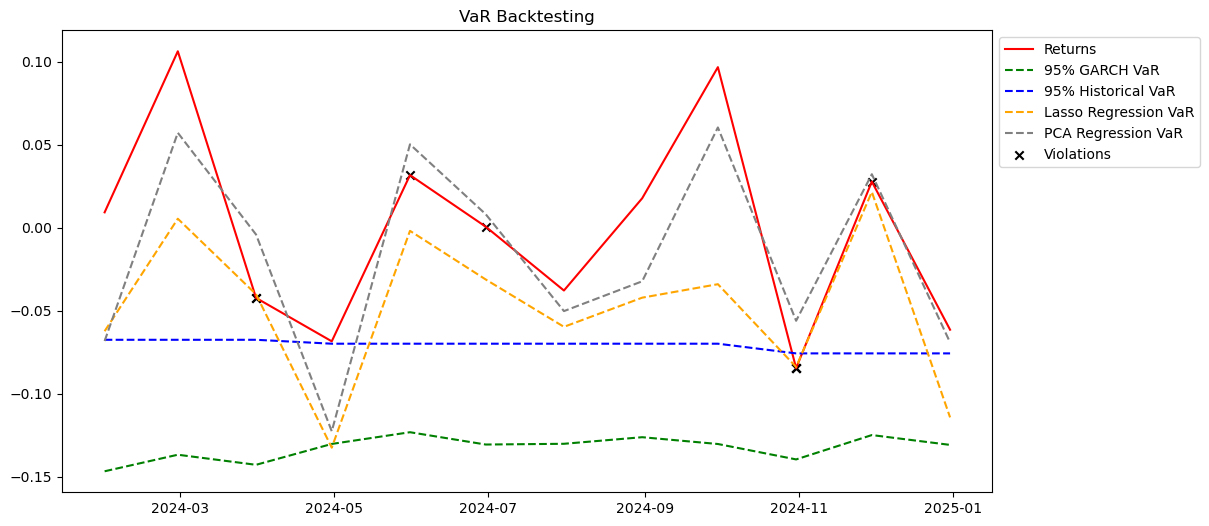

,Model,Violations,Violation Rate,UC p-value,Status
0,GARCH VaR,0/12,0.00%,1.0000,Valid
1,Historical VaR,1/12,8.33%,0.4596,Valid
2,LASSO Regression VaR,2/12,16.67%,0.1184,Valid
3,PCA Regression VaR,5/12,41.67%,0.0002,Invalid


In [11]:
# ===========================
# Compare VaR Estimates
# ===========================
# Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(y_backtest.index, y_backtest, color='red', label='Returns')
plt.plot(y_backtest.index, garch_pred_var, color='green', linestyle='--', label='95% GARCH VaR')
plt.plot(y_backtest.index, hist_pred_var, color='blue', linestyle='--', label='95% Historical VaR')
plt.plot(y_backtest.index, lassoLog_pred_var, color='orange', linestyle='--', label='Lasso Regression VaR')
plt.plot(y_backtest.index, pcaLog_pred_var, color='grey', linestyle='--', label='PCA Regression VaR')
plt.scatter(y_backtest[y_backtest < garch_pred_var].index, 
            y_backtest[y_backtest < garch_pred_var], 
            color='k', marker='x', label='Violations')
plt.scatter(y_backtest[y_backtest < hist_pred_var].index,
            y_backtest[y_backtest < hist_pred_var],
            color='k', marker='x')
plt.scatter(y_backtest[y_backtest < lassoLog_pred_var].index,
            y_backtest[y_backtest < lassoLog_pred_var],
            color='k', marker='x')
plt.scatter(y_backtest[y_backtest < pcaLog_pred_var].index,
            y_backtest[y_backtest < pcaLog_pred_var],
            color='k', marker='x')
plt.title('VaR Backtesting')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Create VaR Summary DataFrame
var_results_df = pd.DataFrame({
    'Model': ['GARCH VaR', 'Historical VaR', 'LASSO Regression VaR', 'PCA Regression VaR'],
    'Violations': [f"{garch_var_violations}/{len(y_backtest)}", 
                   f"{hist_var_violations}/{len(y_backtest)}", 
                   f"{lassoLog_var_violations}/{len(y_backtest)}", 
                   f"{pcaLog_var_violations}/{len(y_backtest)}"],
    'Violation Rate': [garch_var_violations/len(y_backtest), 
                      hist_var_violations/len(y_backtest), 
                      lassoLog_var_violations/len(y_backtest), 
                      pcaLog_var_violations/len(y_backtest)],
    'UC p-value': [garch_uc_pvalue, hist_uc_pvalue, lassoLog_uc_pvalue, pcaLog_uc_pvalue],
    'Status': ['Valid' if p > 0.05 else 'Invalid' 
              for p in [garch_uc_pvalue, hist_uc_pvalue, lassoLog_uc_pvalue, pcaLog_uc_pvalue]]
})

var_results_df['Violation Rate'] = var_results_df['Violation Rate'].map('{:.2%}'.format)
var_results_df['UC p-value'] = var_results_df['UC p-value'].map('{:.4f}'.format)
var_results_df

Note:
1. GARCH VaR is overly conservative, meaning it never underestimated risk but may be too strict, leading to excessive capital reserves.

2. Historical VaR is slightly conservative but statistically valid.

3. LASSO Regression VaR slightly underestimate risk. Its higher violation rate may cause by limited backtest data, or may suggest need for stronger regularization or additional risk factors.

4. PCA Regression VaR fails backtesting, indicating severe risk underestimation—likely due to overfitting or missing risk factors.

In [12]:
# ===========================
# GARCH ES 
# ===========================
def forecast_es(train_data, test_data):
    es_forecasts = []
    model_data = train_data.copy()
    
    for i in range(len(test_data)):
        if i > 0:
            model_data = pd.concat([model_data, test_data.iloc[[i-1]]])
        
        fitted = arch_model(model_data, vol='GARCH', p=1, q=1, dist='t').fit(disp='off')
        cond_vol = fitted.forecast(horizon=1).variance.iloc[-1,0]**0.5
        nu = fitted.params['nu']  # Degrees of freedom for Student's t
        
        # ES formula for Student's t-distribution
        var = -t.ppf(0.95, df=nu) * cond_vol
        es = -cond_vol * (t.pdf(t.ppf(0.95, nu), nu) / 0.05) * (nu + t.ppf(0.95, nu)**2) / (nu - 1)
        es_forecasts.append(es)
    
    return pd.Series(es_forecasts, index=test_data.index)

# Calculate ES using same GARCH model as VaR
garch_pred_es = forecast_es(y_training, y_backtest)

# ===========================
# Historical ES 
# ===========================
def historical_es(returns, window=12, alpha=0.05):
    es = []
    for i in range(len(returns)):
        if i >= window:
            window_returns = returns.iloc[i-window:i]
            var = window_returns.quantile(alpha)
            tail_returns = window_returns[window_returns <= var]
            es.append(tail_returns.mean())
        else:
            es.append(np.nan)
    return pd.Series(es, index=returns.index)

hist_pred_es = historical_es(pd.concat([y_training, y_backtest]), window=12)[len(y_training):]

# ===========================
# LASSO Regresion ES 
# ===========================
lassoLog_es_adjustment = lassoLog_residuals[lassoLog_residuals <= lassoLog_var_adjustment].mean()
lassoLog_pred_es = lassoLog_y_pred_backtest_unlog + lassoLog_es_adjustment

# ===========================
# PCA Regresion ES 
# ===========================
pcaLog_es_adjustment = pcaLog_residuals[pcaLog_residuals <= pcaLog_var_adjustment].mean()
pcaLog_pred_es = pcaLog_y_pred_backtest_unlog + pcaLog_es_adjustment

# ===========================
# Backtest ES 
# ===========================
def es_backtest(realized_returns, var_forecasts, es_forecasts, alpha=0.05):
    """
    Acerbi-Szekely ES backtest (Null: ES model is correct)
    Returns test statistic (should be close to 0 under H0) and p-value
    """
    violations = realized_returns < -np.abs(var_forecasts)
    num_violations = violations.sum()
    
    if num_violations == 0:
        return 0, 0  # No violations to test
    
    ratio = -np.sum(realized_returns[violations]) / (num_violations * es_forecasts[violations].mean())
    test_stat = ratio + 1
    
    # Approximate p-value via Monte Carlo (simulate under H0)
    mc_stats = []
    for _ in range(1000):
        sim_violations = np.random.uniform(size=len(realized_returns)) < alpha
        if sim_violations.sum() > 0:
            mc_ratio = -np.sum(np.random.standard_t(5, size=sim_violations.sum())) / \
                      (sim_violations.sum() * es_forecasts[sim_violations].mean())
            mc_stats.append(mc_ratio + 1)
    
    p_value = (np.array(mc_stats) <= test_stat).mean()
    return p_value, num_violations

garch_es_pvalue, garch_es_violations  = es_backtest(y_backtest, garch_pred_var, garch_pred_es)
hist_es_pvalue, hist_es_violations = es_backtest(y_backtest, hist_pred_var, hist_pred_es)
lassoLog_es_pvalue, lassoLog_es_violations = es_backtest(y_backtest, lassoLog_pred_var, lassoLog_pred_es)
pcaLog_es_pvalue, pcaLog_es_violations = es_backtest(y_backtest, pcaLog_pred_var, pcaLog_pred_es)

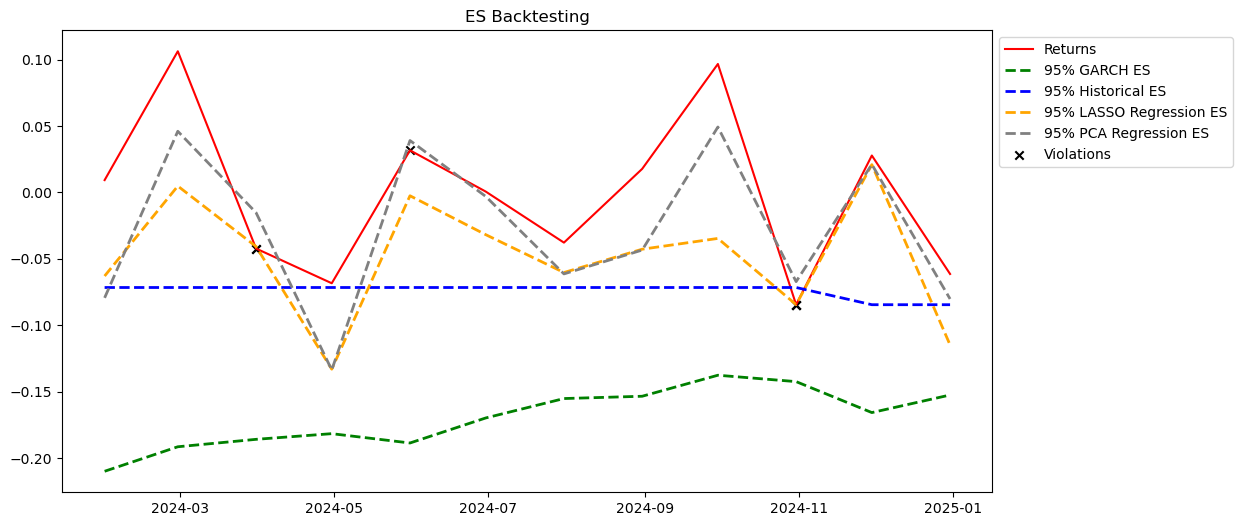

,Model,Violations,Violation Rate,ES p-value,Status
0,GARCH ES,0/12,0.00%,0.0000,Invalid
1,Historical ES,1/12,8.33%,0.4298,Valid
2,LASSO Regression ES,2/12,16.67%,0.4854,Valid
3,PCA Regression ES,2/12,16.67%,0.4452,Valid


In [13]:
# ===========================
# Compare ES Estimates
# ===========================
# Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(y_backtest.index, y_backtest, color='red', label='Returns')
plt.plot(y_backtest.index, garch_pred_es, color='green', linestyle='--', linewidth=2, label='95% GARCH ES')
plt.plot(y_backtest.index, hist_pred_es, color='blue', linestyle='--', linewidth=2, label='95% Historical ES')
plt.plot(y_backtest.index, lassoLog_pred_es, color='orange', linestyle='--', linewidth=2, label='95% LASSO Regression ES')
plt.plot(y_backtest.index, pcaLog_pred_es, color='grey', linestyle='--', linewidth=2, label='95% PCA Regression ES')
plt.scatter(y_backtest[y_backtest < garch_pred_es].index, 
            y_backtest[y_backtest < garch_pred_es], 
            color='k', marker='x', label='Violations')
plt.scatter(y_backtest[y_backtest < hist_pred_es].index,
            y_backtest[y_backtest < hist_pred_es],
            color='k', marker='x')
plt.scatter(y_backtest[y_backtest < lassoLog_pred_es].index,
            y_backtest[y_backtest < lassoLog_pred_es],
            color='k', marker='x')
plt.scatter(y_backtest[y_backtest < pcaLog_pred_es].index,
            y_backtest[y_backtest < pcaLog_pred_es],
            color='k', marker='x')
plt.title('ES Backtesting')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Create ES summary DataFrame
es_results_df = pd.DataFrame({
    'Model': ['GARCH ES', 'Historical ES', 'LASSO Regression ES', 'PCA Regression ES'],
    'Violations': [f"{garch_es_violations}/{len(y_backtest)}", 
                   f"{hist_es_violations}/{len(y_backtest)}", 
                   f"{lassoLog_es_violations}/{len(y_backtest)}", 
                   f"{pcaLog_es_violations}/{len(y_backtest)}"],
    'Violation Rate': [garch_es_violations/len(y_backtest), 
                      hist_es_violations/len(y_backtest), 
                      lassoLog_es_violations/len(y_backtest), 
                      pcaLog_es_violations/len(y_backtest)],
    'ES p-value': [garch_es_pvalue, 
                   hist_es_pvalue, 
                   lassoLog_es_pvalue, 
                   pcaLog_es_pvalue],
    'Status': ['Valid' if p > 0.05 else 'Invalid' 
              for p in [garch_es_pvalue, hist_es_pvalue, lassoLog_es_pvalue, pcaLog_es_pvalue]]
})

es_results_df['Violation Rate'] = es_results_df['Violation Rate'].map('{:.2%}'.format)
es_results_df['ES p-value'] = es_results_df['ES p-value'].map('{:.4f}'.format)
es_results_df

Note:
1. GARCH ES is invalid, suggesting ES predictions are not consistent with actual observed risk.
2. Historical ES, LASSO ES, and PCA ES are all statistically valid. However, LASSO and PCA ES have higher violation rates, likely due to limited backtest data, or suggesting need for additional risk factors.

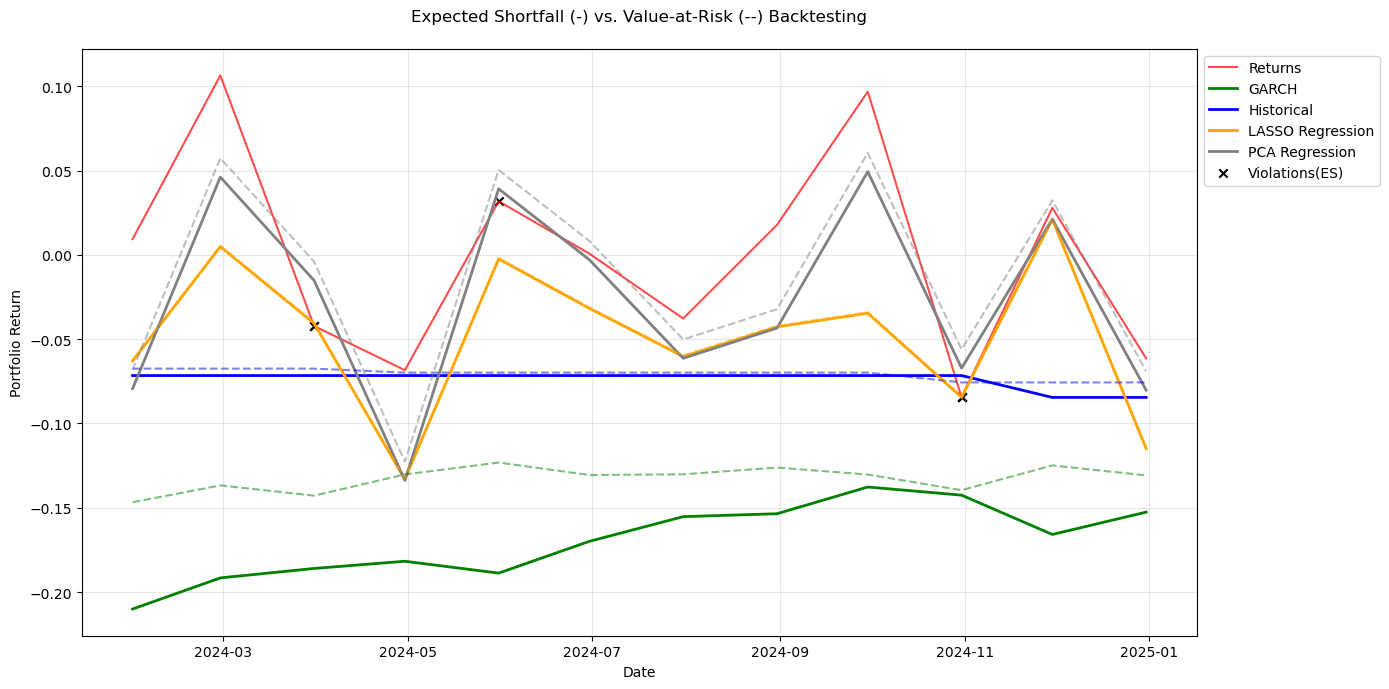

In [14]:
# ===========================
# VaR and ES Summary
# ===========================
plt.figure(figsize=(14, 7))
plt.plot(y_backtest.index, y_backtest, color='red', alpha=0.7, label='Returns')

# ES estimates
plt.plot(y_backtest.index, garch_pred_es, color='green', linestyle='-', linewidth=2, label='GARCH')
plt.plot(y_backtest.index, hist_pred_es, color='blue', linestyle='-', linewidth=2, label='Historical')
plt.plot(y_backtest.index, lassoLog_pred_es, color='orange', linestyle='-', linewidth=2, label='LASSO Regression')
plt.plot(y_backtest.index, pcaLog_pred_es, color='grey', linestyle='-', linewidth=2, label='PCA Regression')

# VaR estimates (dashed lines)
plt.plot(y_backtest.index, garch_pred_var, color='green', linestyle='--', alpha=0.5, label='_nolegend_')
plt.plot(y_backtest.index, hist_pred_var, color='blue', linestyle='--', alpha=0.5, label='_nolegend_')
plt.plot(y_backtest.index, lassoLog_pred_var, color='orange', linestyle='--', alpha=0.5, label='_nolegend_')
plt.plot(y_backtest.index, pcaLog_pred_var, color='grey', linestyle='--', alpha=0.5, label='_nolegend_')

# ES Violations
plt.scatter(y_backtest[y_backtest < garch_pred_es].index, 
            y_backtest[y_backtest < garch_pred_es], 
            color='k', marker='x', label='Violations(ES)')
plt.scatter(y_backtest[y_backtest < hist_pred_es].index,
            y_backtest[y_backtest < hist_pred_es],
            color='k', marker='x')
plt.scatter(y_backtest[y_backtest < lassoLog_pred_es].index,
            y_backtest[y_backtest < lassoLog_pred_es],
            color='k', marker='x')
plt.scatter(y_backtest[y_backtest < pcaLog_pred_es].index,
            y_backtest[y_backtest < pcaLog_pred_es],
            color='k', marker='x')

plt.title('Expected Shortfall (-) vs. Value-at-Risk (--) Backtesting', pad=20)
plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Note:
- GARCH ES is invalid, and GARCH VaR is too conservative, suggesting it may not be a practical choice for risk management.
- Historical ES and VaR are the most reliable risk measures, both passing backtesting with reasonable violation rates.
- LASSO ES and VaR perform well but may underestimate risk slightly. They exhibits higher violation rates, likely due to limitation in backtesting period. Could offer valid insights for risk management.
- PCA Regression fails VaR testing and should not be used for risk estimation.